In [ ]:
import pandas as pd
import numpy as np
import random
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/thesis/dataset/preprocessed_data.csv')
# actual dataset: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/
data = data[data.columns[1:]]
data.head(3)

Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    0              1        140          289          0           0   
1   49    1              2        160          180          0           0   
2   37    0              1        130          283          0           2   

   MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
0    172               1      0.0         0             0  
1    156               1      1.0         2             1  
2     98               1      0.0         0             0

In [ ]:
def setup(number_of_clusters, number_of_clients_in_each_cluster):
  list_data = data.values.tolist()
  total_clients = number_of_clusters * number_of_clients_in_each_cluster
  data_per_client = math.floor(len(list_data)/total_clients)
  curr_counter = 0
  cluster_client_data = []
  for i in range(number_of_clusters):
    cluster_data = []
    for j in range(number_of_clients_in_each_cluster):
      curr_client_data = []
      for k in range(data_per_client):
        curr_client_data.append(list_data[curr_counter])
        curr_counter = curr_counter+1
      cluster_data.append(curr_client_data)
    cluster_client_data.append(cluster_data)
  return cluster_client_data

In [ ]:
ultimate_data = setup(3, 2)

In [ ]:
def data_preperation_for_model_training(cluster_number, client_number_of_that_cluster):
  working_data = ultimate_data[cluster_number][client_number_of_that_cluster]
  X_list = []
  y_list = []
  for each_data in working_data:
    temp = []
    for i in range(11):
      temp.append(each_data[i])
    X_list.append(temp)
    y_list.append(each_data[11])

  X = np.asarray(X_list, dtype=np.float32)
  y = np.asarray(y_list, dtype=np.float32)
  return (X, y)

In [ ]:
def make_model1():
  # Create a Sequential model
  model = Sequential()

  # Add a dense (fully connected) layer with 11 input units and 8 hidden units
  model.add(Dense(8, input_dim=11, activation='relu'))

  # Add a dense layer with 16 hidden units
  model.add(Dense(16, activation='relu'))

  # Add a dense layer with 32 hidden units
  model.add(Dense(32, activation='relu'))

  # Add a dense layer with 16 hidden units
  model.add(Dense(16, activation='relu'))

  # Add a dense layer with 8 hidden units
  model.add(Dense(8, activation='relu'))

  # Add another dense layer with 4 hidden units
  model.add(Dense(4, activation='relu'))

  # Add the output layer with 1 unit and a sigmoid activation function (for binary classification)
  model.add(Dense(1, activation='sigmoid'))

  return model

def make_model2():
  # Create a Sequential model
  model = Sequential()

  # Add a dense (fully connected) layer with 11 input units and 8 hidden units
  model.add(Dense(8, input_dim=11, activation='relu'))

  # Add a dense layer with 16 hidden units
  model.add(Dense(16, activation='relu'))

  # Add a dense layer with 8 hidden units
  model.add(Dense(8, activation='relu'))

  # Add another dense layer with 4 hidden units
  model.add(Dense(4, activation='relu'))

  # Add the output layer with 1 unit and a sigmoid activation function (for binary classification)
  model.add(Dense(1, activation='sigmoid'))

  return model

def make_model3():
  # Create a Sequential model
  model = Sequential()

  # Add a dense (fully connected) layer with 11 input units and 8 hidden units
  model.add(Dense(8, input_dim=11, activation='relu'))

  # Add another dense layer with 4 hidden units
  model.add(Dense(4, activation='relu'))

  # Add the output layer with 1 unit and a sigmoid activation function (for binary classification)
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
def accuracy_loss_graph_plotting(model, cluster_number, client_number):

  # summarize history for accuracy
  plt.plot(model.history.history['accuracy'])
  plt.title(f'cluster: {cluster_number} :: client {client_number} :: model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['Train'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(model.history.history['loss'])
  plt.title(f'cluster: {cluster_number} :: client {client_number} :: model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Train'], loc='upper left')
  plt.show()

In [ ]:
def latest_model_training(cluster_number, client_number, X, y, latest_model, epochs, batch_size):
  # Compile the model
  latest_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Train the model on your data
  latest_model.fit(X, y, epochs=epochs, batch_size=batch_size)

  # graph plotting
  accuracy_loss_graph_plotting(latest_model, cluster_number, client_number)

  # Evaluate the model
  loss, accuracy = latest_model.evaluate(X, y)
  print(f'Loss: {loss:.2f}, Accuracy: {accuracy*100:.2f}%')

  return latest_model

In [ ]:
def cluster_selection_algorithm(number_of_clusters, number_of_clusters_every_iteration):
  selected_clusters = []
  count = 0
  while(count<number_of_clusters_every_iteration):
    current_cluster_number = random.randint(0, number_of_clusters-1)
    if current_cluster_number not in selected_clusters:
      selected_clusters.append(current_cluster_number)
      count = count + 1
  return selected_clusters

In [ ]:
def model_aggregation(list_of_models):
  # implementing fedavg algorithm: https://www.codespeedy.com/get_weights-and-set_weights-functions-in-keras-layers/

  updated_model = list_of_models[0]

  # jot down all the weights and the biases of the model as the form of numpy array
  all_layers = []
  all_biases = []
  for curr_model in list_of_models:
    intermediate_layers = []
    intermediate_biases = []
    for layer in curr_model.layers:
      intermediate_layers.append(layer.get_weights()[0])
      intermediate_biases.append(layer.get_weights()[1])
    all_layers.append(intermediate_layers)
    all_biases.append(intermediate_biases)

  # avg the weights
  updated_layers = []
  for col in range(len(all_layers[0])):
    sum_layers = all_layers[0][col]
    for row in range(1, len(all_layers)):
      sum_layers = np.add(sum_layers, all_layers[row][col])
    avg_layer_weight = np.divide(sum_layers, len(all_layers))
    updated_layers.append(avg_layer_weight)

  # avg the biases
  updated_biases = []
  for col in range(len(all_biases[0])):
    sum_biases = all_biases[0][col]
    for row in range(1, len(all_biases)):
      sum_biases = np.add(sum_biases, all_biases[row][col])
    avg_biases_weight = np.divide(sum_biases, len(all_biases))
    updated_biases.append(avg_biases_weight)

  # usning set_weights() to update the weights
  count = 0
  for layer in updated_model.layers:
    layer.set_weights([updated_layers[count], updated_biases[count]])
    count = count + 1

  return updated_model

In [ ]:
def multi_model_aggregation(dict_of_models):
  final_dict = {}
  for curr_model_index in dict_of_models.keys():
    all_models = dict_of_models[curr_model_index]
    if(len(all_models)>1):
      updated_model = model_aggregation(all_models)
      final_dict[curr_model_index] = updated_model
    elif (len(all_models)==1):
      final_dict[curr_model_index] = all_models[0]
  return final_dict

In [ ]:
def train_client(cluster_number, client_number, latest_model, epochs, batch_size):
  # prepare the data for this particular client
  (X, y) = data_preperation_for_model_training(cluster_number, client_number)

  # model training for this client
  updated_model = latest_model_training(cluster_number, client_number, X, y, latest_model, epochs, batch_size)

  #return the updated model
  return updated_model

In [ ]:
def model_selection(number_of_models):
  return random.randrange(0, number_of_models)

In [ ]:
def CFL(iterations, epochs, batch_size, number_of_clusters, number_of_clients_in_each_cluster, number_of_clusters_every_iteration):
  if(number_of_clusters_every_iteration>number_of_clusters):
    raise Exception("Number of clusters in every iteration have to be less or equals to the total number of available clusters for the setup")

  for itr in range(iterations):
    global current_models

    # select the cluster
    selected_clusters = cluster_selection_algorithm(number_of_clusters, number_of_clusters_every_iteration)

    cluster_level_aggregated_model = {0:[], 1:[], 2:[]}

    for curr_cluster_number in selected_clusters:
      client_trained_model_for_single_cluster = {0:[], 1:[], 2:[]}

      for curr_client_number in range(number_of_clients_in_each_cluster):

        # select latest model from the current global models
        model_index = model_selection(3)
        latest_mdoel = current_models[model_index]

        updated_model = train_client(curr_cluster_number, curr_client_number, latest_mdoel, epochs, batch_size)
        client_trained_model_for_single_cluster[model_index].append(updated_model)

      # cluster level aggregation
      aggregated_model = multi_model_aggregation(client_trained_model_for_single_cluster)

      for curr_model_index in aggregated_model.keys():
        cluster_level_aggregated_model[curr_model_index].append(aggregated_model[curr_model_index])

    global_aggregated_model = multi_model_aggregation(cluster_level_aggregated_model)

    # update the current global models
    for curr_model_index in global_aggregated_model.keys():
      current_models[curr_model_index] = global_aggregated_model[curr_model_index]

In [ ]:
# global model (updated)
current_models = [make_model1(), make_model2(), make_model3()]

In [ ]:
current_models[0].summary()
current_models[1].summary()
current_models[2].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 96        
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 4)                 36        
                                                                 
 dense_6 (Dense)             (None, 1)                 5

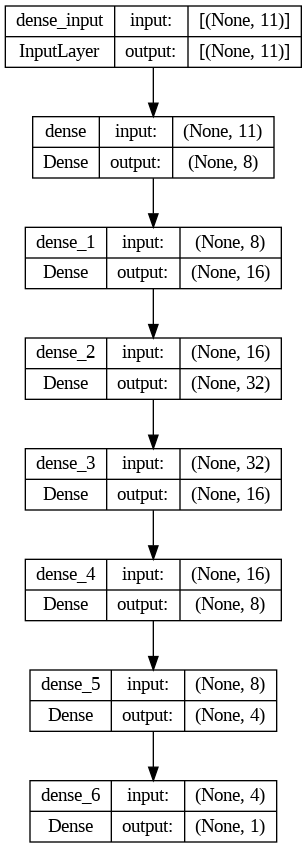

In [ ]:
# visualize the model
plot_model(current_models[0], to_file='model0_plot.png', show_shapes=True, show_layer_names=True)

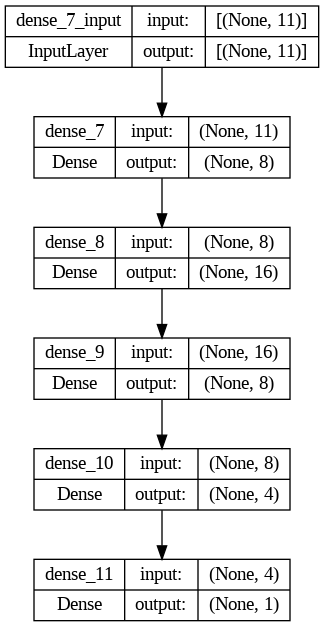

In [ ]:
plot_model(current_models[1], to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

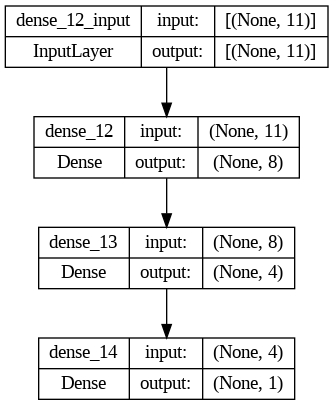

In [ ]:
plot_model(current_models[2], to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/100
16/16 [==============================] - 2s 3ms/step - loss: 0.3960 - accuracy: 0.8693
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3815 - accuracy: 0.8824
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3659 - accuracy: 0.8824
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3612 - accuracy: 0.8824
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 0.3629 - accuracy: 0.8824
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3620 - accuracy: 0.8824
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3547 - accuracy: 0.8824
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3772 - accuracy: 0.8824
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3693 - accuracy: 0.8824
Epoch 10/100
16/16 [==============================] - 0s 2ms/step - loss: 0.3718 - accuracy: 0.8824
Epoch 11/

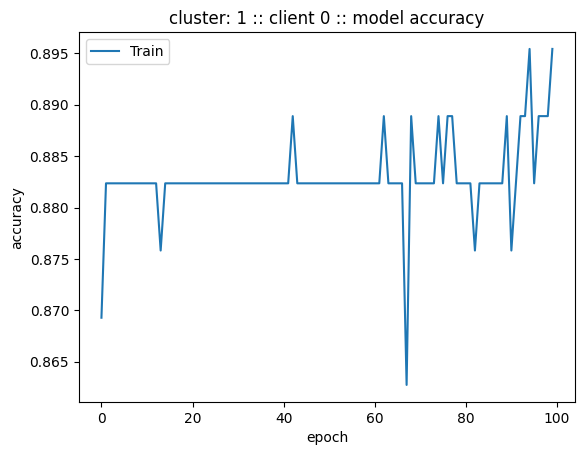

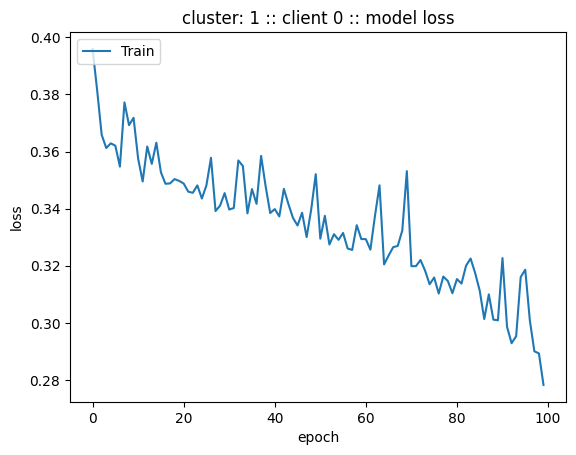

5/5 [==============================] - 0s 3ms/step - loss: 0.2771 - accuracy: 0.8954
Loss: 0.28, Accuracy: 89.54%
Epoch 1/100
16/16 [==============================] - 1s 4ms/step - loss: 17.0383 - accuracy: 0.2680
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 5.9102 - accuracy: 0.5490
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 5.3980 - accuracy: 0.6340
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 4.8028 - accuracy: 0.6144
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 4.5898 - accuracy: 0.5882
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 4.4140 - accuracy: 0.5948
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 4.1932 - accuracy: 0.5817
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 4.0195 - accuracy: 0.5817
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 3.8030 - accuracy: 0

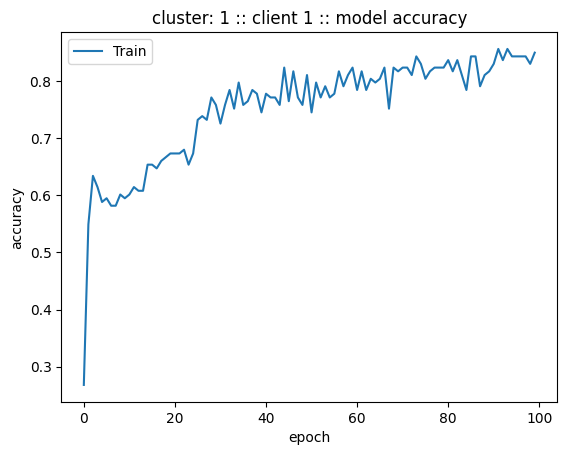

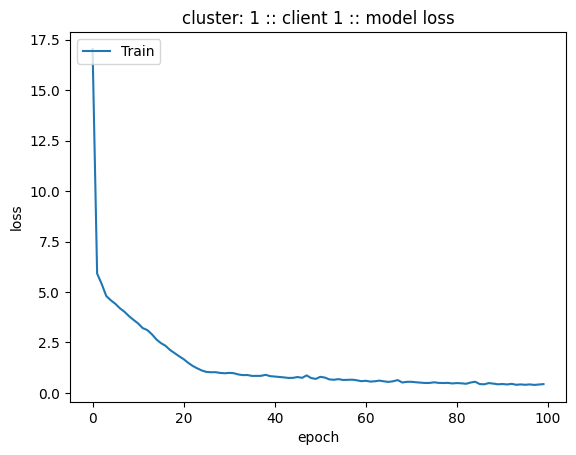

5/5 [==============================] - 0s 4ms/step - loss: 0.4073 - accuracy: 0.8301
Loss: 0.41, Accuracy: 83.01%
Epoch 1/100
16/16 [==============================] - 1s 3ms/step - loss: 19.5222 - accuracy: 0.5294
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 4.3874 - accuracy: 0.5294
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 1.7290 - accuracy: 0.5294
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 1.2681 - accuracy: 0.5294
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 0.9559 - accuracy: 0.5294
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.8018 - accuracy: 0.5294
Epoch 7/100
16/16 [==============================] - 0s 2ms/step - loss: 0.7247 - accuracy: 0.5294
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6627 - accuracy: 0.5294
Epoch 9/100
16/16 [==============================] - 0s 2ms/step - loss: 0.6597 - accuracy: 0

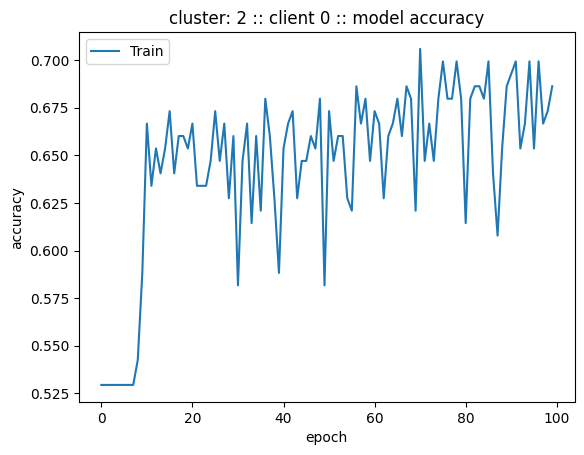

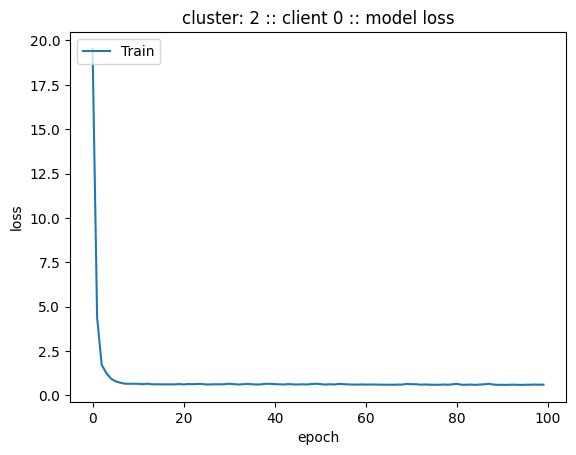

5/5 [==============================] - 0s 4ms/step - loss: 0.5896 - accuracy: 0.6863
Loss: 0.59, Accuracy: 68.63%
Epoch 1/100
16/16 [==============================] - 1s 2ms/step - loss: 0.5905 - accuracy: 0.7843
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5758 - accuracy: 0.7647
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5551 - accuracy: 0.7647
Epoch 4/100
16/16 [==============================] - 0s 2ms/step - loss: 0.5562 - accuracy: 0.7582
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5685 - accuracy: 0.7712
Epoch 6/100
16/16 [==============================] - 0s 2ms/step - loss: 0.5457 - accuracy: 0.7386
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5448 - accuracy: 0.7647
Epoch 8/100
16/16 [==============================] - 0s 2ms/step - loss: 0.5413 - accuracy: 0.7516
Epoch 9/100
16/16 [==============================] - 0s 2ms/step - loss: 0.5465 - accuracy: 0.

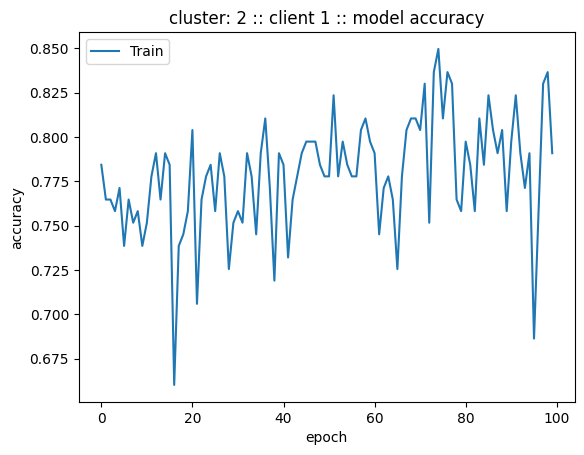

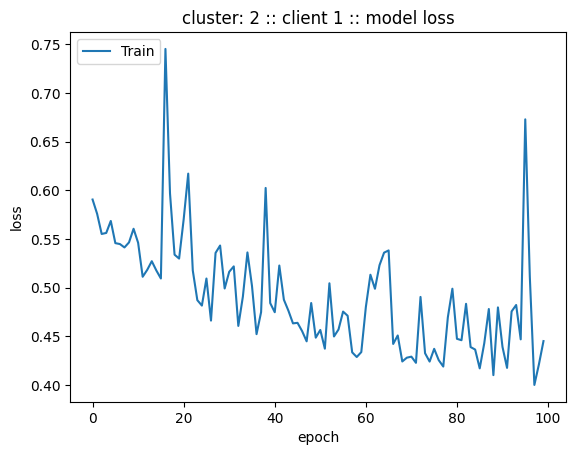

5/5 [==============================] - 0s 5ms/step - loss: 0.4959 - accuracy: 0.7712
Loss: 0.50, Accuracy: 77.12%
Epoch 1/100
16/16 [==============================] - 1s 3ms/step - loss: 0.5413 - accuracy: 0.7582
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5107 - accuracy: 0.7516
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5055 - accuracy: 0.7647
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5284 - accuracy: 0.7647
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 0.5320 - accuracy: 0.7647
Epoch 6/100
16/16 [==============================] - 0s 2ms/step - loss: 0.5886 - accuracy: 0.7255
Epoch 7/100
16/16 [==============================] - 0s 2ms/step - loss: 0.5138 - accuracy: 0.7647
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5486 - accuracy: 0.7320
Epoch 9/100
16/16 [==============================] - 0s 2ms/step - loss: 0.5181 - accuracy: 0.

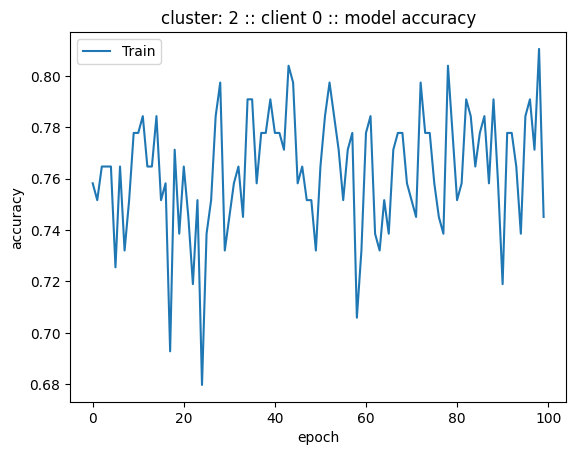

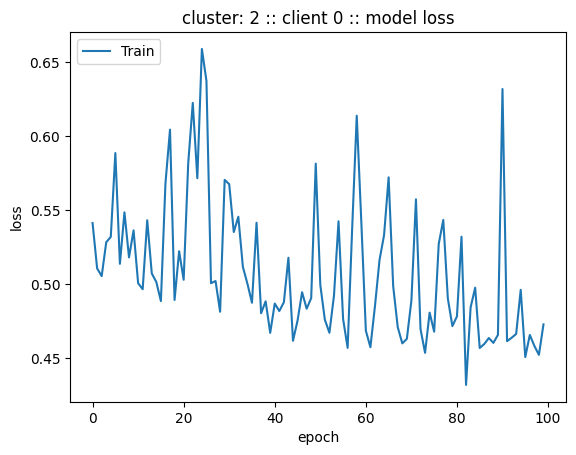

5/5 [==============================] - 0s 4ms/step - loss: 0.4503 - accuracy: 0.8039
Loss: 0.45, Accuracy: 80.39%
Epoch 1/100
16/16 [==============================] - 1s 3ms/step - loss: 0.6867 - accuracy: 0.5359
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.6340
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6310 - accuracy: 0.6405
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6838 - accuracy: 0.6405
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.5490
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5949 - accuracy: 0.6797
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6723 - accuracy: 0.6340
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6199 - accuracy: 0.6275
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6130 - accuracy: 0.

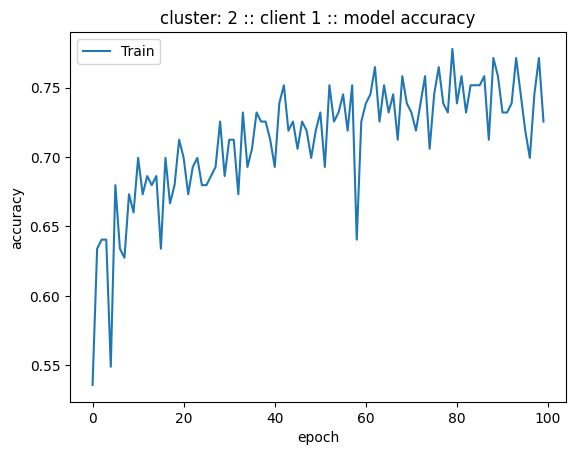

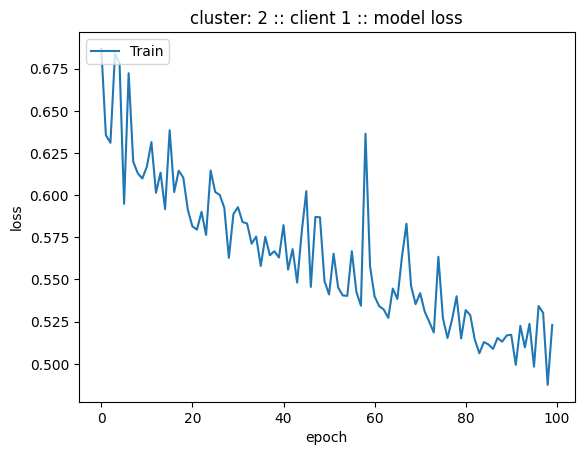

5/5 [==============================] - 0s 4ms/step - loss: 0.5661 - accuracy: 0.7255
Loss: 0.57, Accuracy: 72.55%
Epoch 1/100
16/16 [==============================] - 1s 4ms/step - loss: 0.7348 - accuracy: 0.7712
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6764 - accuracy: 0.7451
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5807 - accuracy: 0.7908
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5648 - accuracy: 0.7843
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4952 - accuracy: 0.7974
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4668 - accuracy: 0.8170
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4738 - accuracy: 0.7908
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5154 - accuracy: 0.8039
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4748 - accuracy: 0.

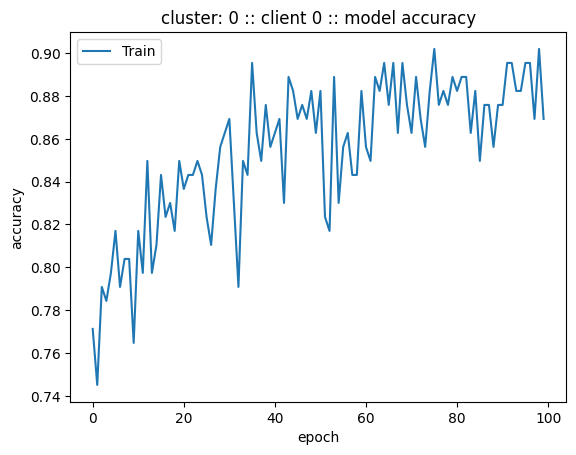

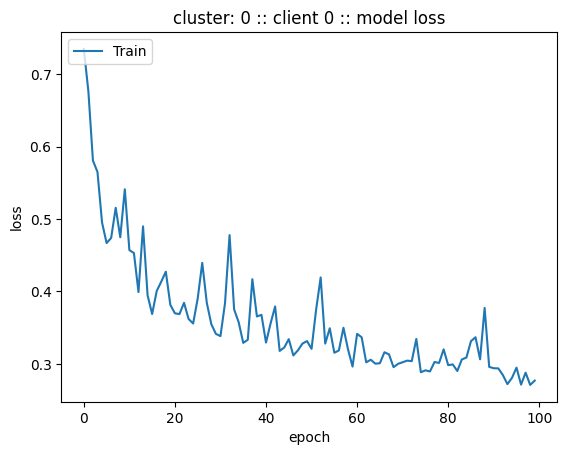

5/5 [==============================] - 0s 4ms/step - loss: 0.2683 - accuracy: 0.8889
Loss: 0.27, Accuracy: 88.89%
Epoch 1/100
16/16 [==============================] - 1s 4ms/step - loss: 0.2734 - accuracy: 0.9346
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2635 - accuracy: 0.9020
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2297 - accuracy: 0.9477
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.2352 - accuracy: 0.9150
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.2536 - accuracy: 0.9412
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.2259 - accuracy: 0.9412
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.2169 - accuracy: 0.9346
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.2290 - accuracy: 0.9216
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.2120 - accuracy: 0.

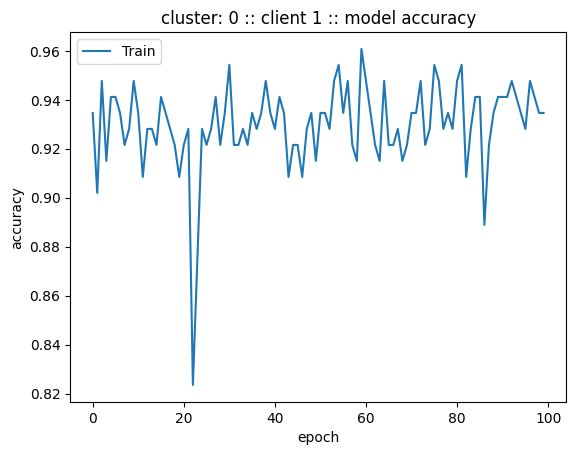

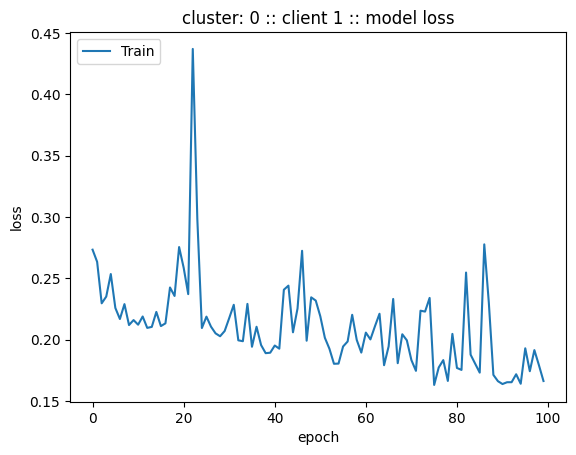

5/5 [==============================] - 0s 4ms/step - loss: 0.1642 - accuracy: 0.9477
Loss: 0.16, Accuracy: 94.77%
Epoch 1/100
16/16 [==============================] - 1s 3ms/step - loss: 0.5401 - accuracy: 0.8366
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4908 - accuracy: 0.8824
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4783 - accuracy: 0.8889
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4735 - accuracy: 0.8954
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4711 - accuracy: 0.8954
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4609 - accuracy: 0.9020
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4609 - accuracy: 0.8889
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4536 - accuracy: 0.9020
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4537 - accuracy: 0.

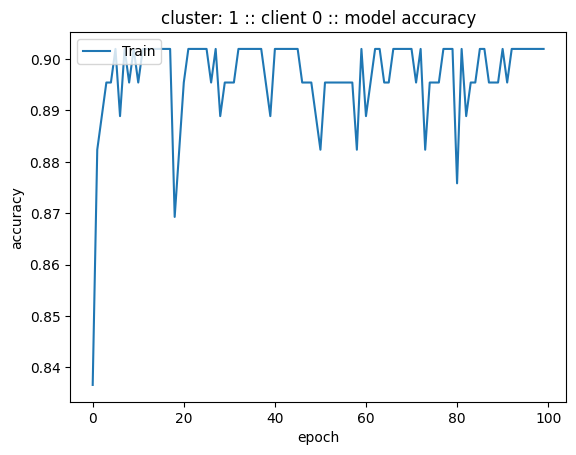

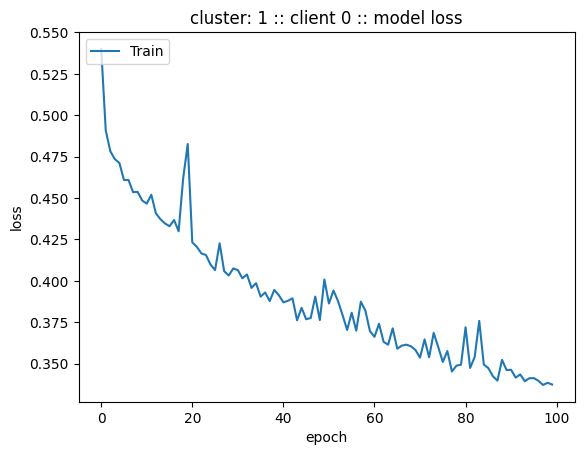

5/5 [==============================] - 0s 4ms/step - loss: 0.3343 - accuracy: 0.9020
Loss: 0.33, Accuracy: 90.20%
Epoch 1/100
16/16 [==============================] - 1s 2ms/step - loss: 0.5713 - accuracy: 0.7974
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3995 - accuracy: 0.8758
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3844 - accuracy: 0.8627
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3846 - accuracy: 0.8824
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3820 - accuracy: 0.8693
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4157 - accuracy: 0.8693
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4022 - accuracy: 0.8562
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4081 - accuracy: 0.8562
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3526 - accuracy: 0.

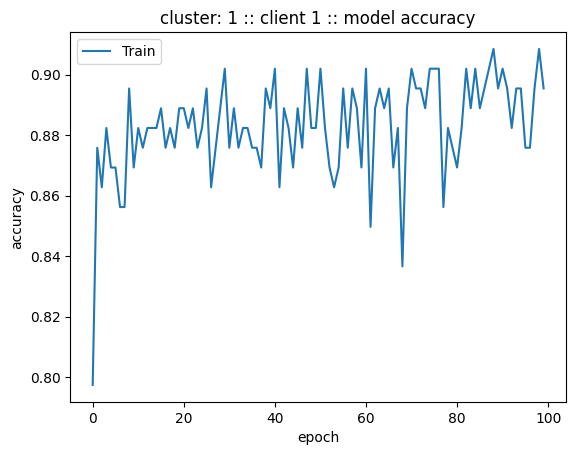

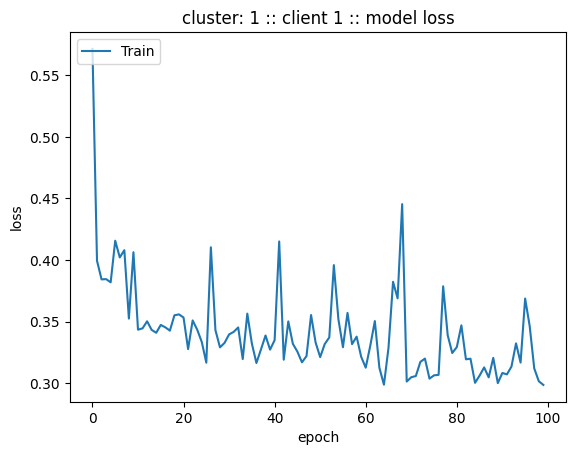

5/5 [==============================] - 0s 3ms/step - loss: 0.3060 - accuracy: 0.9020
Loss: 0.31, Accuracy: 90.20%
Epoch 1/100
16/16 [==============================] - 1s 3ms/step - loss: 0.5175 - accuracy: 0.7386
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4917 - accuracy: 0.7843
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4960 - accuracy: 0.7778
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4785 - accuracy: 0.7974
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4821 - accuracy: 0.7647
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4869 - accuracy: 0.7908
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4663 - accuracy: 0.7908
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4841 - accuracy: 0.7712
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4622 - accuracy: 0.

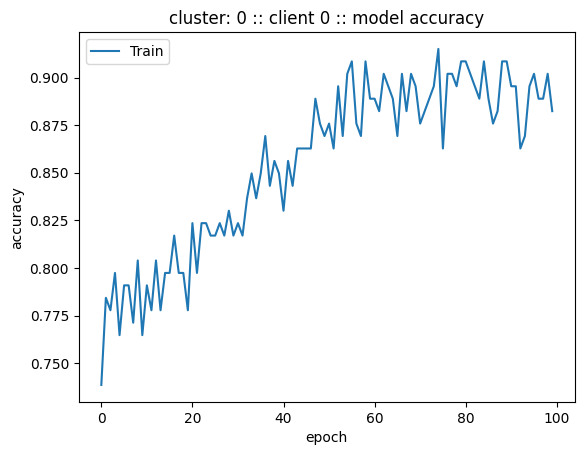

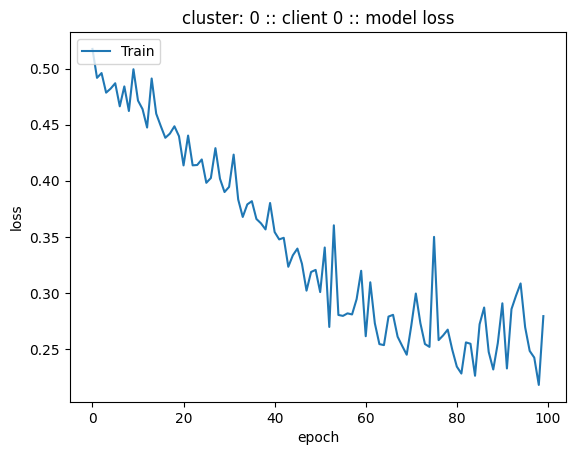

5/5 [==============================] - 0s 5ms/step - loss: 0.2189 - accuracy: 0.9150
Loss: 0.22, Accuracy: 91.50%
Epoch 1/100
16/16 [==============================] - 1s 4ms/step - loss: 0.6948 - accuracy: 0.6013
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5794 - accuracy: 0.6797
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5759 - accuracy: 0.6797
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5621 - accuracy: 0.7124
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5563 - accuracy: 0.6993
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5519 - accuracy: 0.6993
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5351 - accuracy: 0.7255
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5243 - accuracy: 0.7190
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5119 - accuracy: 0.

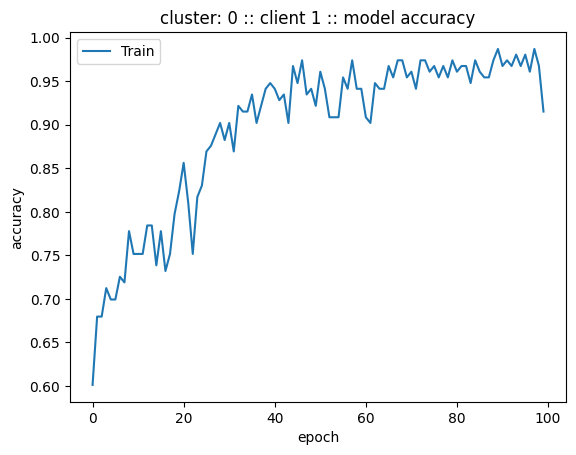

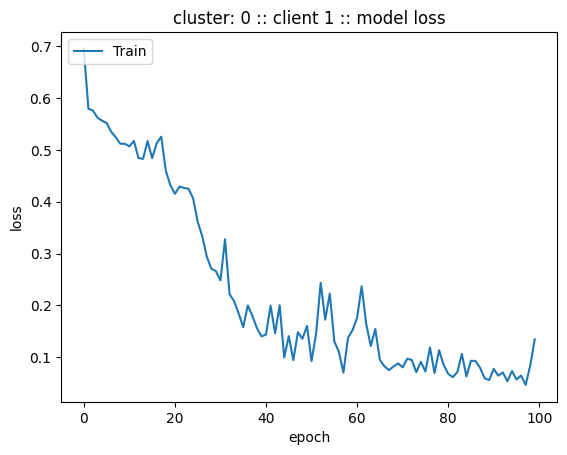

5/5 [==============================] - 0s 4ms/step - loss: 0.0902 - accuracy: 0.9542
Loss: 0.09, Accuracy: 95.42%
Epoch 1/100
16/16 [==============================] - 1s 3ms/step - loss: 0.4904 - accuracy: 0.8039
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3812 - accuracy: 0.8627
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4903 - accuracy: 0.8039
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3695 - accuracy: 0.8366
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 0.3422 - accuracy: 0.8627
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3374 - accuracy: 0.8627
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3257 - accuracy: 0.8824
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3159 - accuracy: 0.8562
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3082 - accuracy: 0.

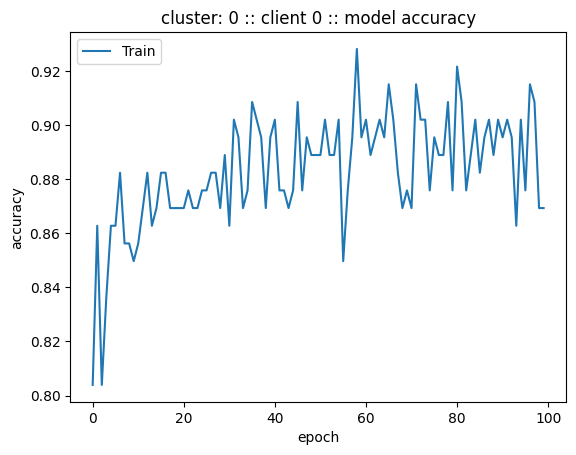

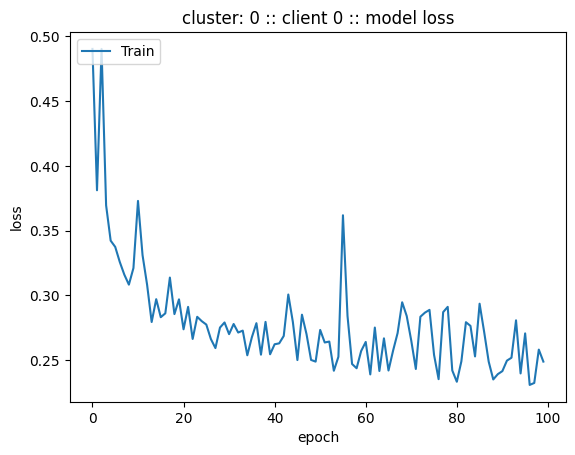

5/5 [==============================] - 0s 4ms/step - loss: 0.2453 - accuracy: 0.9150
Loss: 0.25, Accuracy: 91.50%
Epoch 1/100
16/16 [==============================] - 2s 4ms/step - loss: 0.2800 - accuracy: 0.9085
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0847 - accuracy: 0.9608
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0630 - accuracy: 0.9673
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0655 - accuracy: 0.9608
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.1352 - accuracy: 0.9477
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0886 - accuracy: 0.9673
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0751 - accuracy: 0.9608
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0903 - accuracy: 0.9608
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0884 - accuracy: 0.

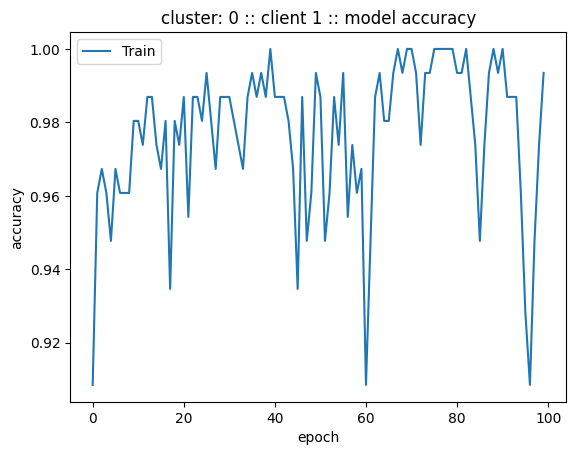

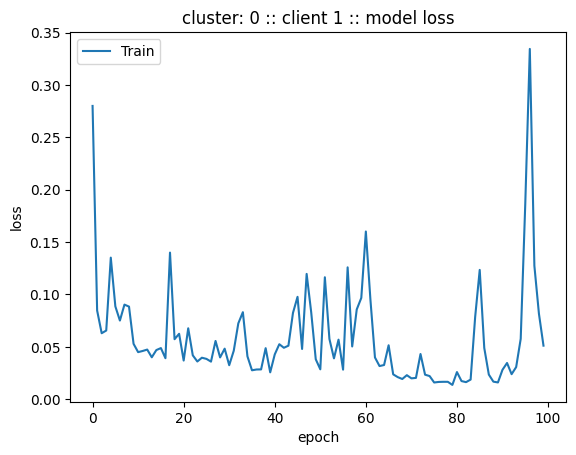

5/5 [==============================] - 0s 4ms/step - loss: 0.0403 - accuracy: 1.0000
Loss: 0.04, Accuracy: 100.00%
Epoch 1/100
16/16 [==============================] - 2s 3ms/step - loss: 1.3160 - accuracy: 0.5686
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4712 - accuracy: 0.8497
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4253 - accuracy: 0.8693
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4210 - accuracy: 0.8758
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4118 - accuracy: 0.8758
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4033 - accuracy: 0.8758
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3958 - accuracy: 0.8758
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3919 - accuracy: 0.8758
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3900 - accuracy: 0

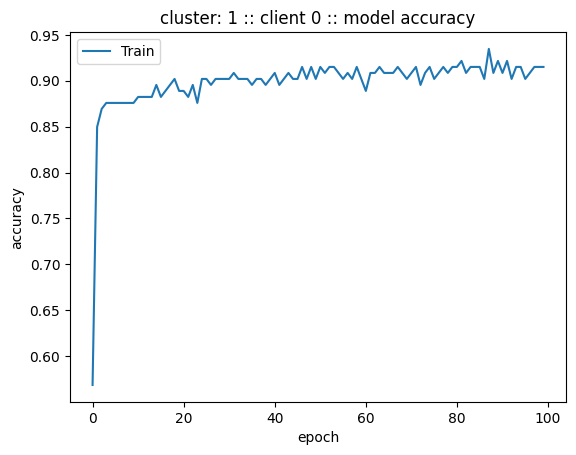

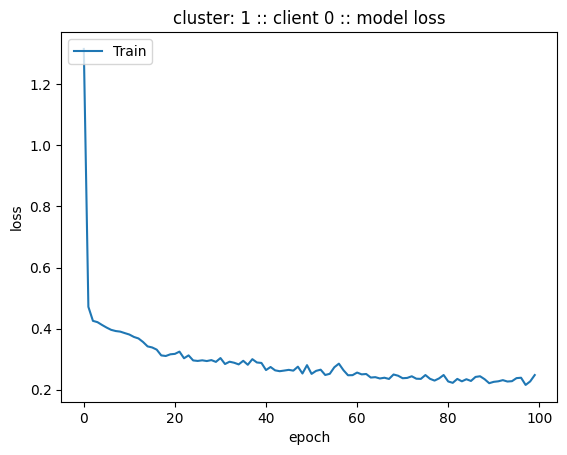

5/5 [==============================] - 0s 5ms/step - loss: 0.2093 - accuracy: 0.9216
Loss: 0.21, Accuracy: 92.16%
Epoch 1/100
16/16 [==============================] - 1s 4ms/step - loss: 0.5494 - accuracy: 0.8627
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4618 - accuracy: 0.8497
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3867 - accuracy: 0.8562
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.3599 - accuracy: 0.8758
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.3433 - accuracy: 0.8758
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3273 - accuracy: 0.8824
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3257 - accuracy: 0.8889
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3465 - accuracy: 0.8497
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3083 - accuracy: 0.

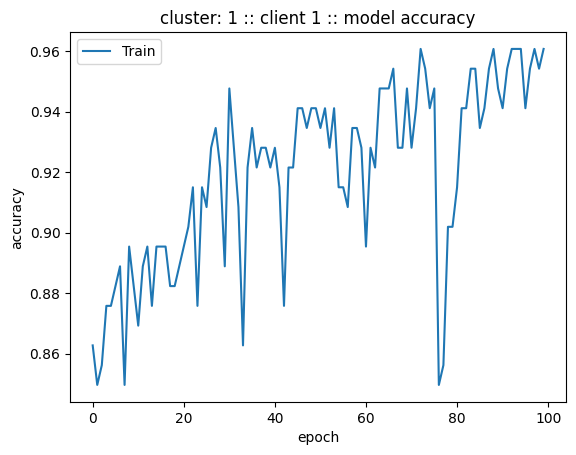

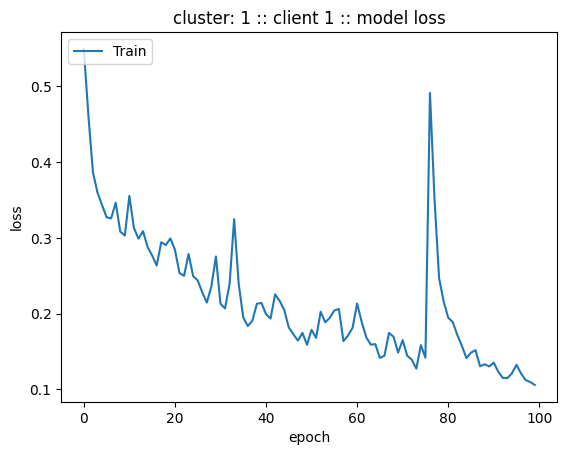

5/5 [==============================] - 0s 4ms/step - loss: 0.0944 - accuracy: 0.9608
Loss: 0.09, Accuracy: 96.08%
Epoch 1/100
16/16 [==============================] - 2s 6ms/step - loss: 0.7724 - accuracy: 0.8562
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4685 - accuracy: 0.9150
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.3567 - accuracy: 0.9020
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2533 - accuracy: 0.8889
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2361 - accuracy: 0.8954
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2259 - accuracy: 0.9085
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2268 - accuracy: 0.9085
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2237 - accuracy: 0.9085
Epoch 9/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2189 - accuracy: 0.

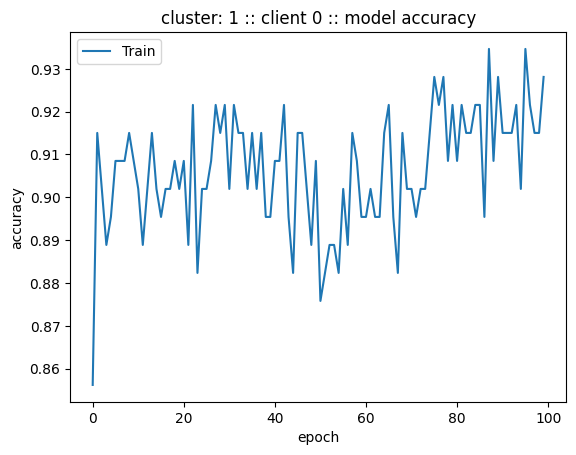

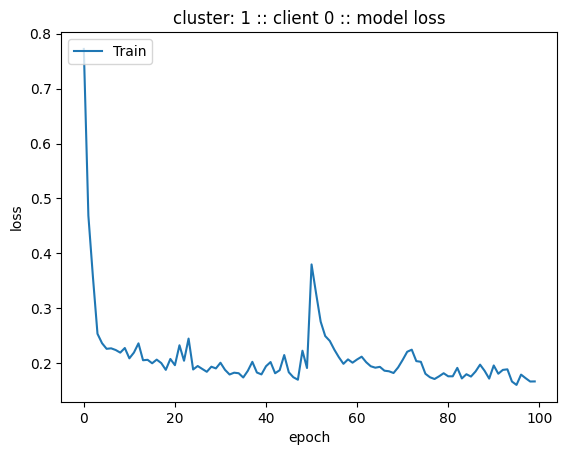

5/5 [==============================] - 0s 4ms/step - loss: 0.1498 - accuracy: 0.9346
Loss: 0.15, Accuracy: 93.46%
Epoch 1/100
16/16 [==============================] - 2s 5ms/step - loss: 0.4030 - accuracy: 0.8627
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.3216 - accuracy: 0.8889
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2820 - accuracy: 0.9150
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2474 - accuracy: 0.9085
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2313 - accuracy: 0.9020
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2644 - accuracy: 0.9150
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.1973 - accuracy: 0.9281
Epoch 8/100
16/16 [==============================] - 0s 5ms/step - loss: 0.1831 - accuracy: 0.9281
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2047 - accuracy: 0.

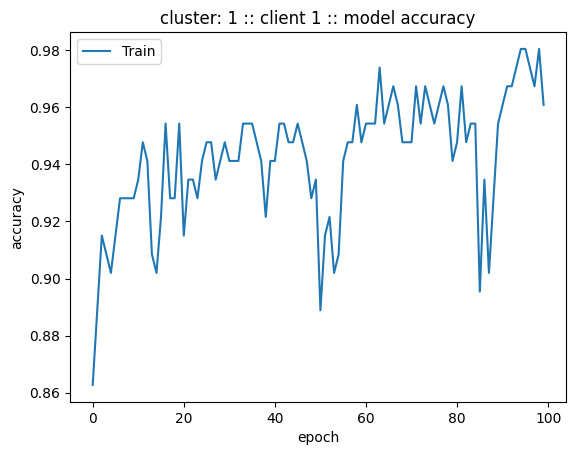

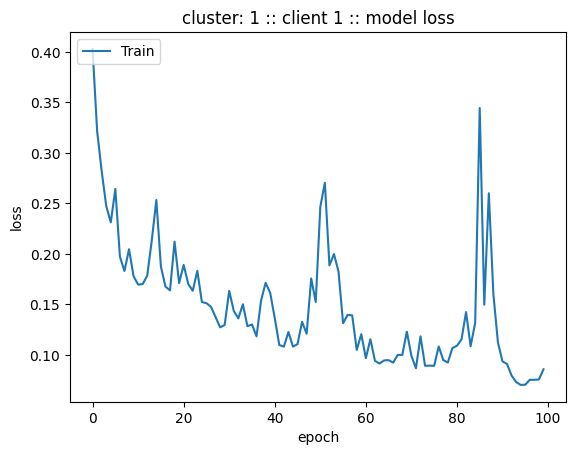

5/5 [==============================] - 0s 7ms/step - loss: 0.0598 - accuracy: 0.9804
Loss: 0.06, Accuracy: 98.04%
Epoch 1/100
16/16 [==============================] - 2s 4ms/step - loss: 2.1589 - accuracy: 0.6340
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 1.2225 - accuracy: 0.6601
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.9275 - accuracy: 0.7255
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.8236 - accuracy: 0.7059
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7346 - accuracy: 0.7451
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6825 - accuracy: 0.7190
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6334 - accuracy: 0.7582
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6068 - accuracy: 0.7386
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5857 - accuracy: 0.

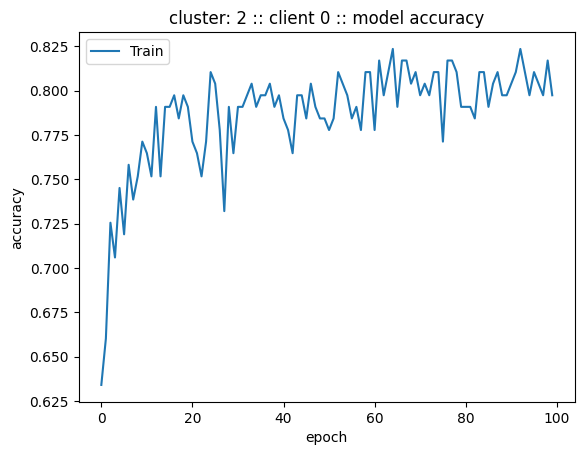

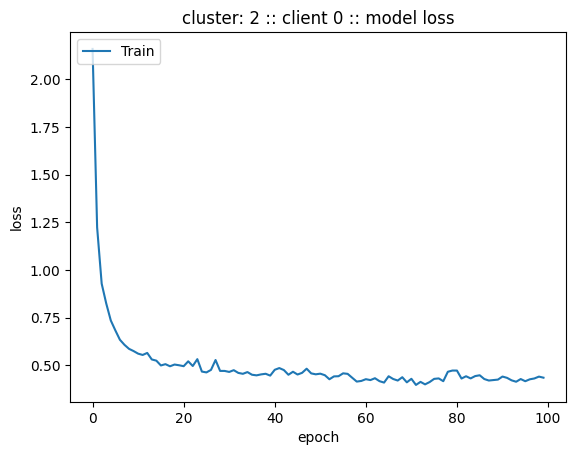

5/5 [==============================] - 0s 10ms/step - loss: 0.3969 - accuracy: 0.8235
Loss: 0.40, Accuracy: 82.35%
Epoch 1/100
16/16 [==============================] - 2s 8ms/step - loss: 0.6895 - accuracy: 0.7255
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6439 - accuracy: 0.7386
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5426 - accuracy: 0.7255
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5136 - accuracy: 0.7320
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5346 - accuracy: 0.7320
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5030 - accuracy: 0.7451
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4943 - accuracy: 0.7451
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4783 - accuracy: 0.7647
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4827 - accuracy: 0

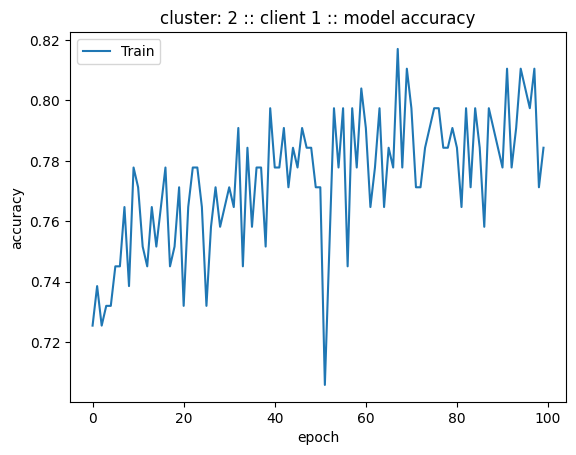

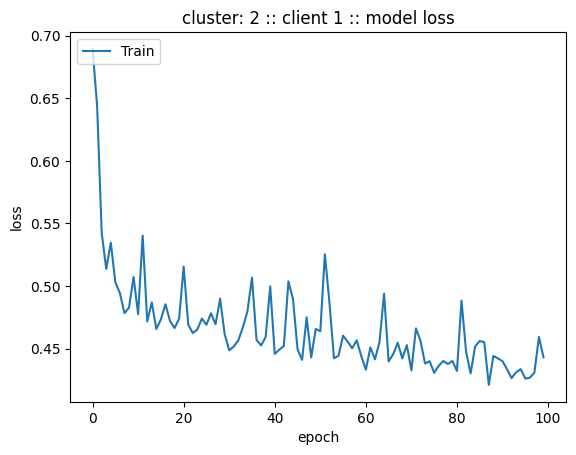

5/5 [==============================] - 0s 4ms/step - loss: 0.4167 - accuracy: 0.7908
Loss: 0.42, Accuracy: 79.08%
Epoch 1/100
16/16 [==============================] - 2s 4ms/step - loss: 0.5656 - accuracy: 0.7712
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5045 - accuracy: 0.7712
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4973 - accuracy: 0.7647
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5045 - accuracy: 0.7712
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5005 - accuracy: 0.7712
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4873 - accuracy: 0.7647
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4890 - accuracy: 0.7974
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4773 - accuracy: 0.7647
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4798 - accuracy: 0.

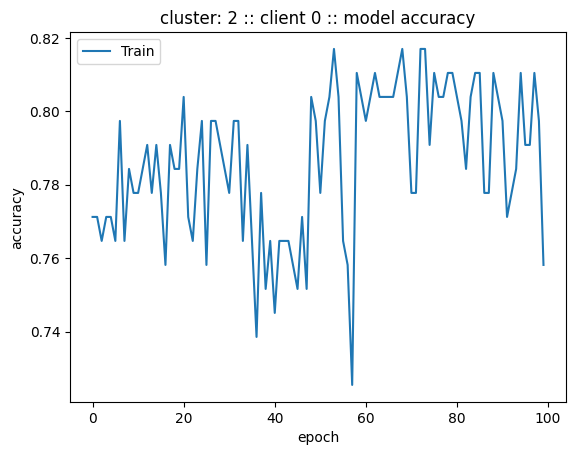

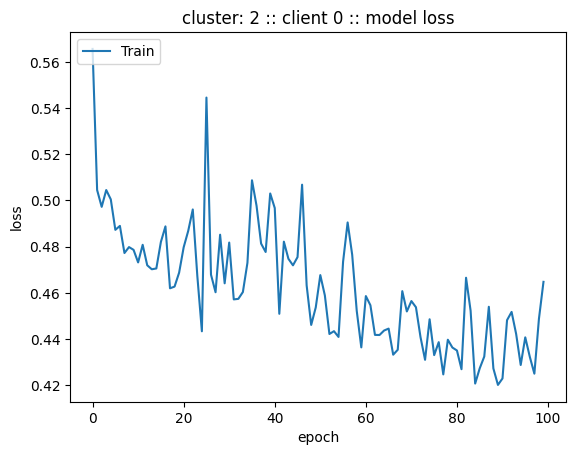

5/5 [==============================] - 0s 4ms/step - loss: 0.4472 - accuracy: 0.7974
Loss: 0.45, Accuracy: 79.74%
Epoch 1/100
16/16 [==============================] - 1s 4ms/step - loss: 0.6058 - accuracy: 0.7124
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6152 - accuracy: 0.6993
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6064 - accuracy: 0.7386
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6067 - accuracy: 0.7516
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5865 - accuracy: 0.7190
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5760 - accuracy: 0.7124
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5689 - accuracy: 0.7190
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5674 - accuracy: 0.7320
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5582 - accuracy: 0.

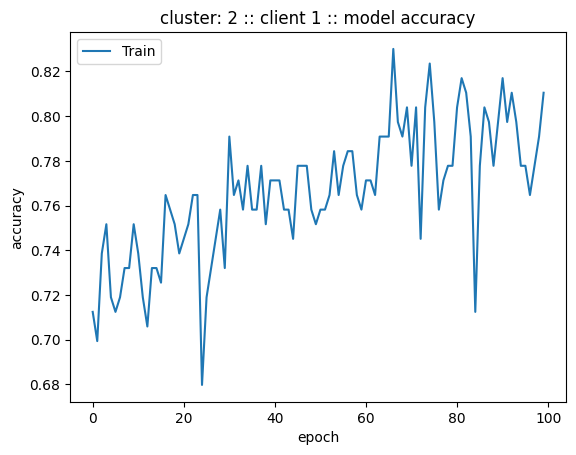

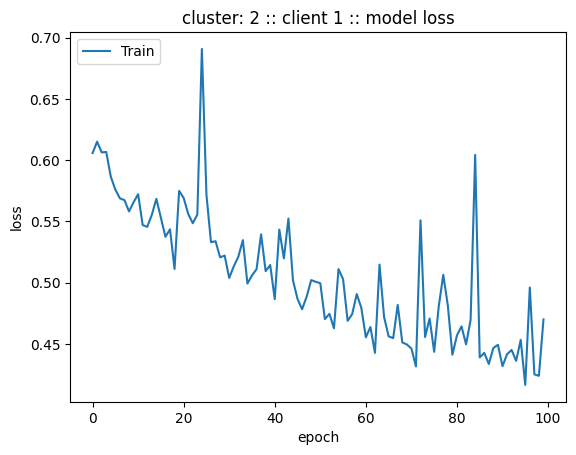

5/5 [==============================] - 0s 4ms/step - loss: 0.4159 - accuracy: 0.7908
Loss: 0.42, Accuracy: 79.08%
Epoch 1/100
16/16 [==============================] - 2s 5ms/step - loss: 2.7476 - accuracy: 0.5359
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5124 - accuracy: 0.8824
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4665 - accuracy: 0.8824
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3247 - accuracy: 0.8562
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2902 - accuracy: 0.8627
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.3053 - accuracy: 0.8693
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2696 - accuracy: 0.8758
Epoch 8/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2520 - accuracy: 0.8758
Epoch 9/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2396 - accuracy: 0.

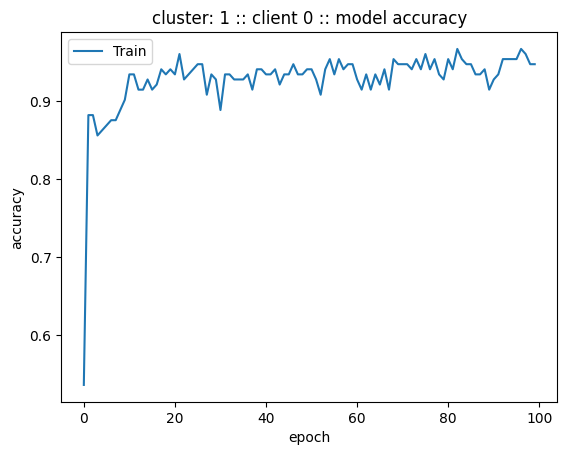

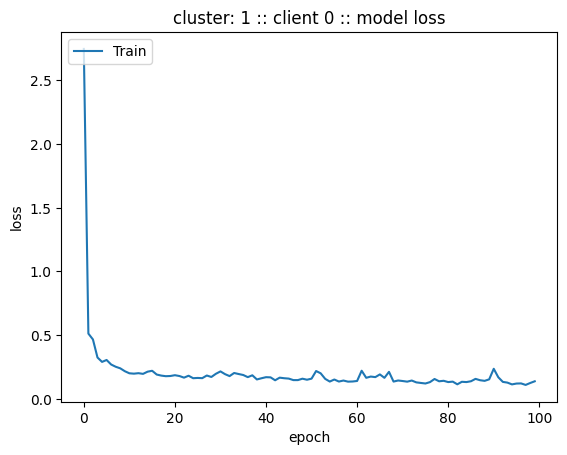

5/5 [==============================] - 0s 6ms/step - loss: 0.1434 - accuracy: 0.9477
Loss: 0.14, Accuracy: 94.77%
Epoch 1/100
16/16 [==============================] - 1s 6ms/step - loss: 0.3537 - accuracy: 0.8824
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.3119 - accuracy: 0.8954
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.3459 - accuracy: 0.8758
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.3157 - accuracy: 0.9020
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3301 - accuracy: 0.8693
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3313 - accuracy: 0.8889
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3151 - accuracy: 0.8889
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3111 - accuracy: 0.8954
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3371 - accuracy: 0.

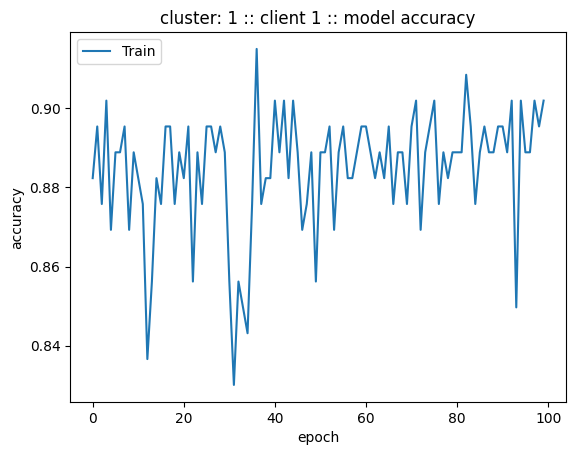

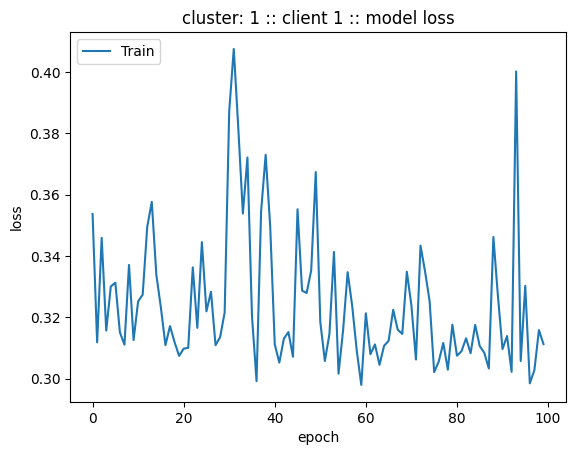

5/5 [==============================] - 0s 4ms/step - loss: 0.3179 - accuracy: 0.8954
Loss: 0.32, Accuracy: 89.54%
Epoch 1/100
16/16 [==============================] - 2s 4ms/step - loss: 0.4449 - accuracy: 0.7908
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4409 - accuracy: 0.7908
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4555 - accuracy: 0.7843
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4623 - accuracy: 0.7647
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4280 - accuracy: 0.7908
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4096 - accuracy: 0.8170
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4150 - accuracy: 0.8105
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4166 - accuracy: 0.8039
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4160 - accuracy: 0.

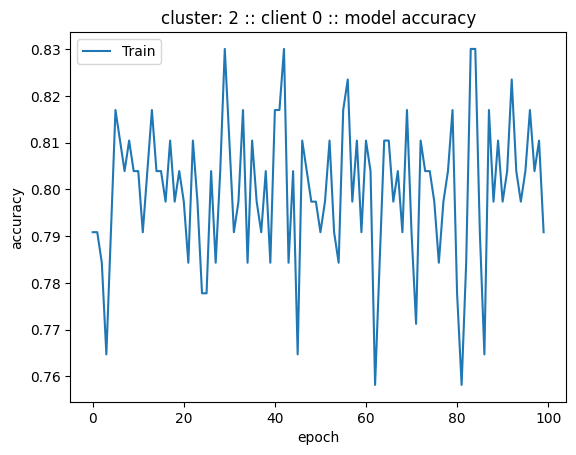

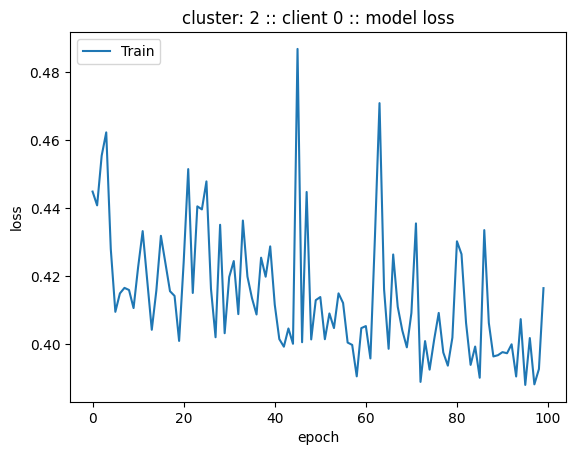

5/5 [==============================] - 0s 4ms/step - loss: 0.4076 - accuracy: 0.7908
Loss: 0.41, Accuracy: 79.08%
Epoch 1/100
16/16 [==============================] - 2s 4ms/step - loss: 0.4942 - accuracy: 0.7974
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4663 - accuracy: 0.7974
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4396 - accuracy: 0.7974
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4393 - accuracy: 0.8105
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4395 - accuracy: 0.8039
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4385 - accuracy: 0.7908
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4508 - accuracy: 0.8039
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4299 - accuracy: 0.7778
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4479 - accuracy: 0.

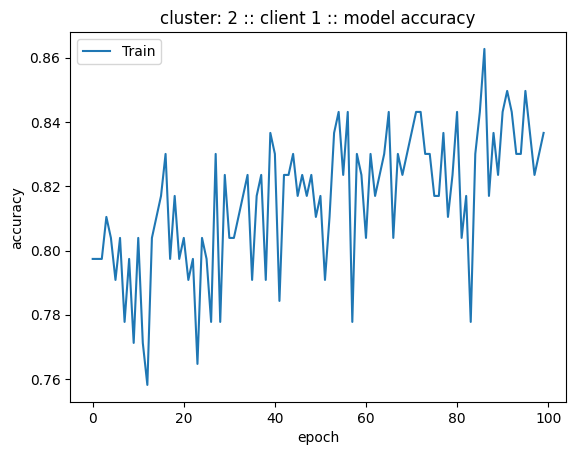

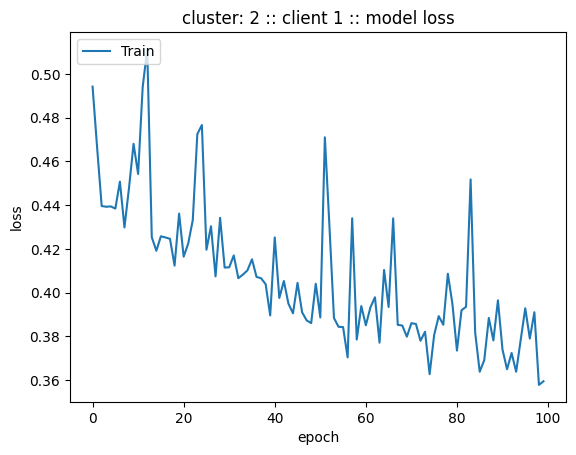

5/5 [==============================] - 0s 4ms/step - loss: 0.3537 - accuracy: 0.8366
Loss: 0.35, Accuracy: 83.66%
Epoch 1/100
16/16 [==============================] - 1s 4ms/step - loss: 0.4336 - accuracy: 0.8758
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3780 - accuracy: 0.8693
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3629 - accuracy: 0.8627
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3447 - accuracy: 0.8758
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3363 - accuracy: 0.8693
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3286 - accuracy: 0.8693
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3232 - accuracy: 0.8693
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3215 - accuracy: 0.8758
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3117 - accuracy: 0.

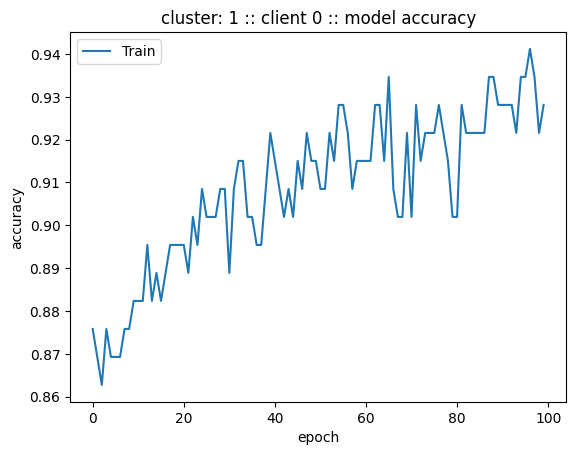

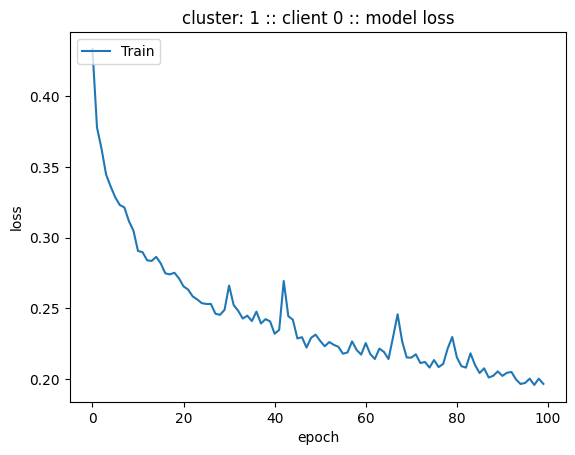

5/5 [==============================] - 0s 4ms/step - loss: 0.1879 - accuracy: 0.9346
Loss: 0.19, Accuracy: 93.46%
Epoch 1/100
16/16 [==============================] - 1s 3ms/step - loss: 0.3219 - accuracy: 0.8693
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3367 - accuracy: 0.9085
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3350 - accuracy: 0.8889
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3160 - accuracy: 0.8889
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3093 - accuracy: 0.8889
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3133 - accuracy: 0.9020
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3023 - accuracy: 0.8889
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.2993 - accuracy: 0.8889
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2977 - accuracy: 0.

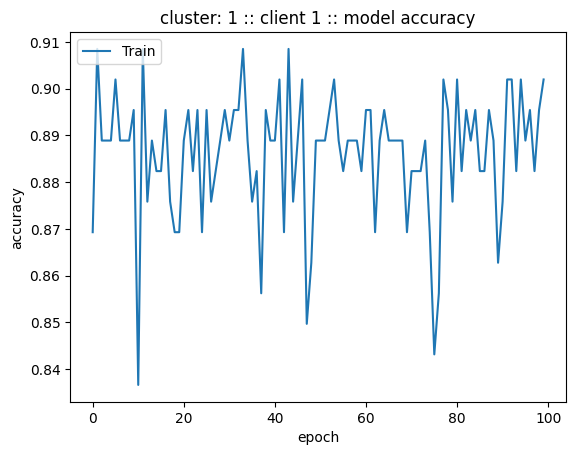

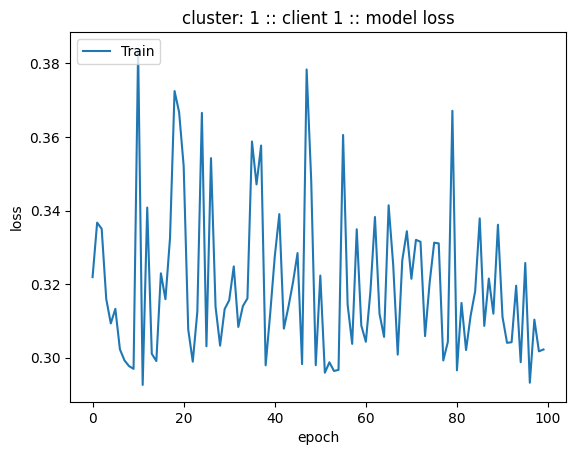

5/5 [==============================] - 0s 3ms/step - loss: 0.2949 - accuracy: 0.8954
Loss: 0.29, Accuracy: 89.54%
Epoch 1/100
16/16 [==============================] - 2s 4ms/step - loss: 0.9159 - accuracy: 0.7386
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6582 - accuracy: 0.7386
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5680 - accuracy: 0.7778
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5093 - accuracy: 0.7712
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4672 - accuracy: 0.7843
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4434 - accuracy: 0.7908
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4444 - accuracy: 0.7974
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4376 - accuracy: 0.7974
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4322 - accuracy: 0.

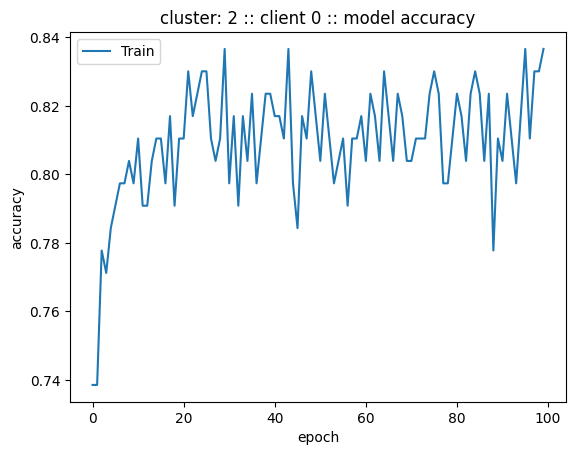

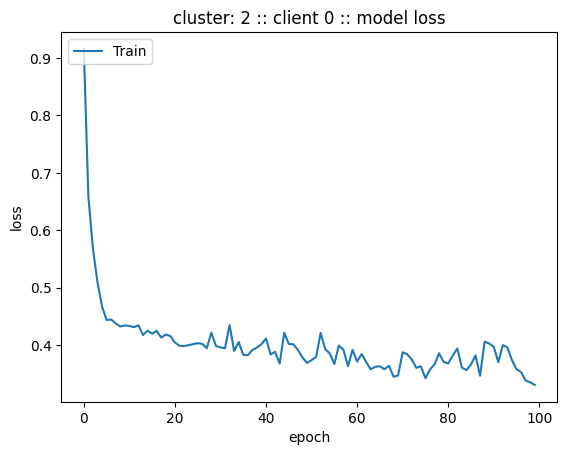

5/5 [==============================] - 0s 4ms/step - loss: 0.3200 - accuracy: 0.8431
Loss: 0.32, Accuracy: 84.31%
Epoch 1/100
16/16 [==============================] - 2s 5ms/step - loss: 0.6383 - accuracy: 0.7255
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5414 - accuracy: 0.7516
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4764 - accuracy: 0.7582
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4642 - accuracy: 0.7778
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4665 - accuracy: 0.7386
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4338 - accuracy: 0.7712
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4527 - accuracy: 0.7647
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4233 - accuracy: 0.7843
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4271 - accuracy: 0.

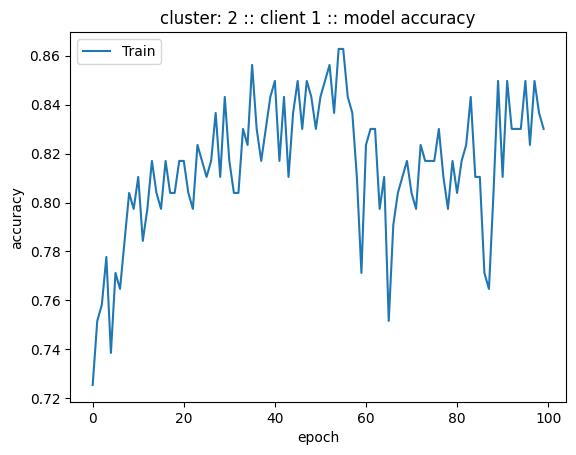

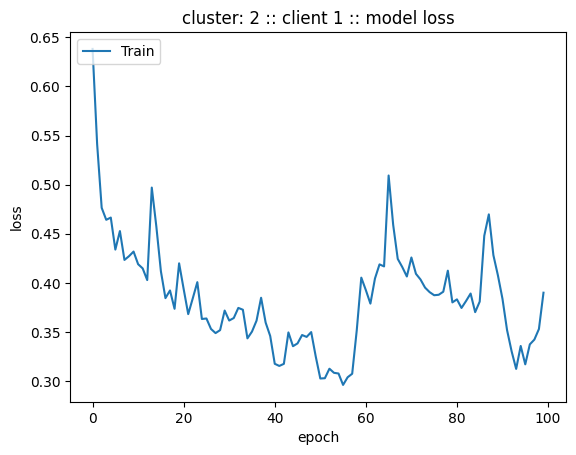

5/5 [==============================] - 0s 5ms/step - loss: 0.3326 - accuracy: 0.8366
Loss: 0.33, Accuracy: 83.66%
Epoch 1/100
16/16 [==============================] - 2s 4ms/step - loss: 0.5855 - accuracy: 0.8039
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3435 - accuracy: 0.8693
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3634 - accuracy: 0.8693
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3383 - accuracy: 0.8693
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3231 - accuracy: 0.8824
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.2950 - accuracy: 0.8824
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2895 - accuracy: 0.8889
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.2890 - accuracy: 0.8824
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.2702 - accuracy: 0.

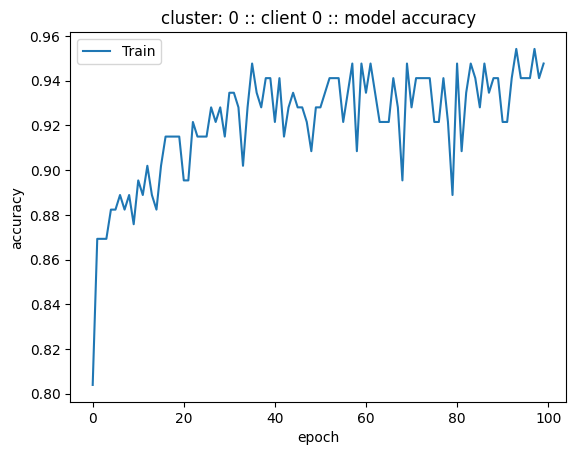

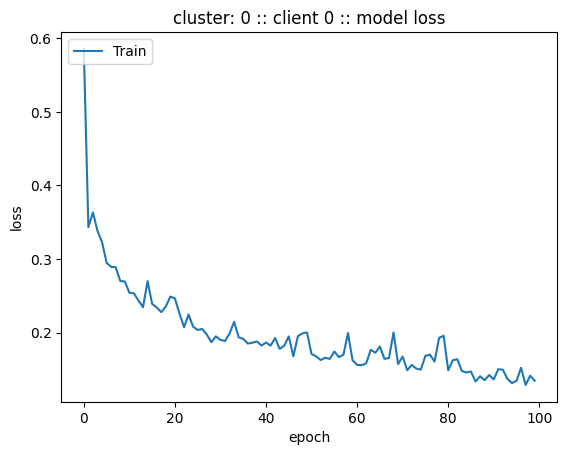

5/5 [==============================] - 0s 4ms/step - loss: 0.1303 - accuracy: 0.9477
Loss: 0.13, Accuracy: 94.77%
Epoch 1/100
16/16 [==============================] - 2s 5ms/step - loss: 0.2972 - accuracy: 0.9150
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.2571 - accuracy: 0.9477
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.1742 - accuracy: 0.9412
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.1432 - accuracy: 0.9608
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.1266 - accuracy: 0.9542
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.1120 - accuracy: 0.9673
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.1134 - accuracy: 0.9608
Epoch 8/100
16/16 [==============================] - 0s 5ms/step - loss: 0.1002 - accuracy: 0.9673
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0897 - accuracy: 0.

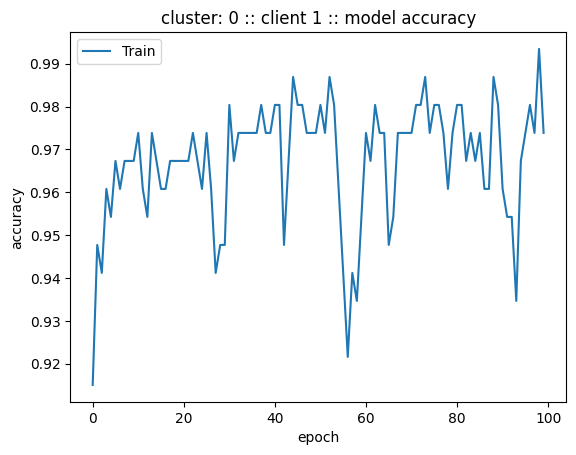

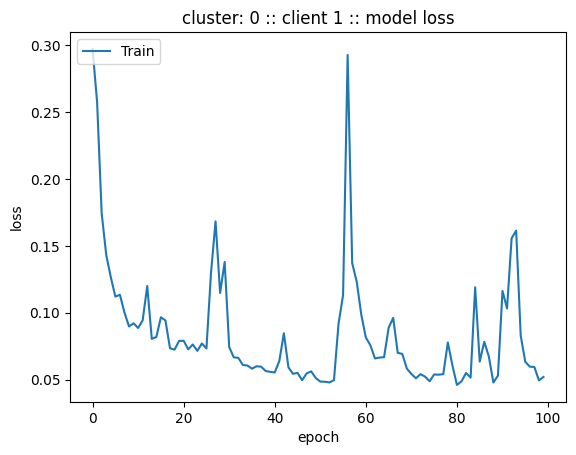

5/5 [==============================] - 0s 4ms/step - loss: 0.0410 - accuracy: 0.9869
Loss: 0.04, Accuracy: 98.69%
Epoch 1/100
16/16 [==============================] - 2s 8ms/step - loss: 1.1744 - accuracy: 0.9085
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.9475 - accuracy: 0.8889
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5914 - accuracy: 0.9085
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4444 - accuracy: 0.9150
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4113 - accuracy: 0.9085
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.3506 - accuracy: 0.9085
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2927 - accuracy: 0.9150
Epoch 8/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2810 - accuracy: 0.9150
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2610 - accuracy: 0.

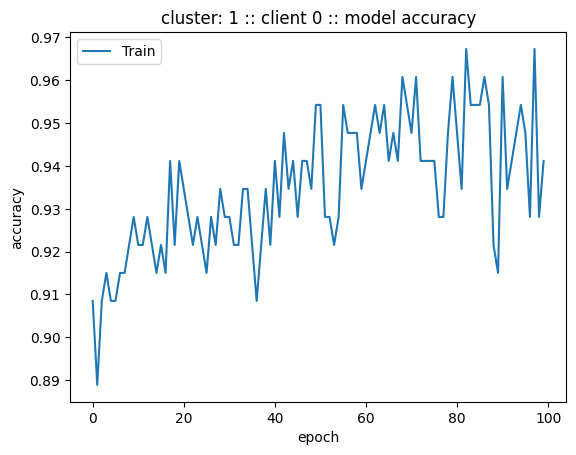

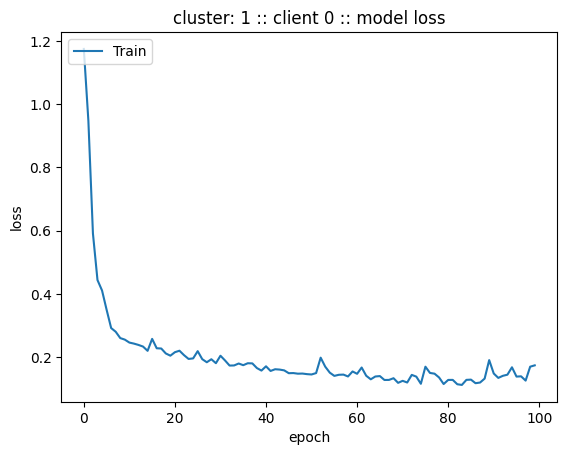

5/5 [==============================] - 0s 4ms/step - loss: 0.1339 - accuracy: 0.9608
Loss: 0.13, Accuracy: 96.08%
Epoch 1/100
16/16 [==============================] - 2s 4ms/step - loss: 0.5981 - accuracy: 0.8301
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4279 - accuracy: 0.8497
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3675 - accuracy: 0.8627
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3416 - accuracy: 0.8824
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3107 - accuracy: 0.8824
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3055 - accuracy: 0.9020
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2722 - accuracy: 0.9085
Epoch 8/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2862 - accuracy: 0.8889
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2696 - accuracy: 0.

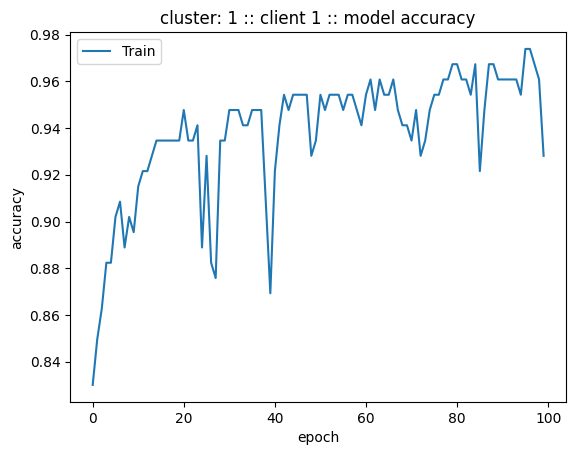

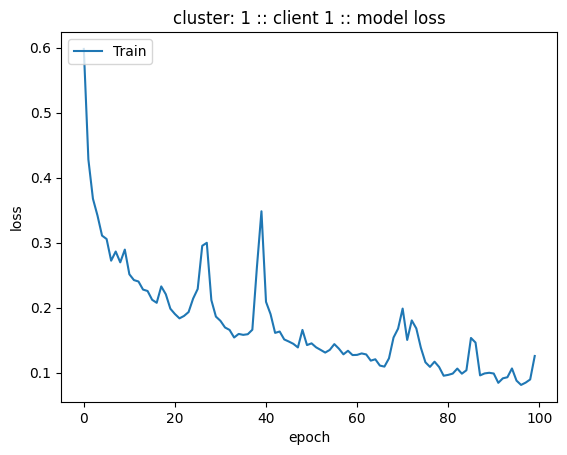

5/5 [==============================] - 0s 4ms/step - loss: 0.1496 - accuracy: 0.9346
Loss: 0.15, Accuracy: 93.46%
Epoch 1/100
16/16 [==============================] - 1s 4ms/step - loss: 0.8487 - accuracy: 0.7124
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6364 - accuracy: 0.7582
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5890 - accuracy: 0.7451
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5530 - accuracy: 0.8039
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5300 - accuracy: 0.7778
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5364 - accuracy: 0.8170
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5341 - accuracy: 0.7908
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5770 - accuracy: 0.8105
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5189 - accuracy: 0.

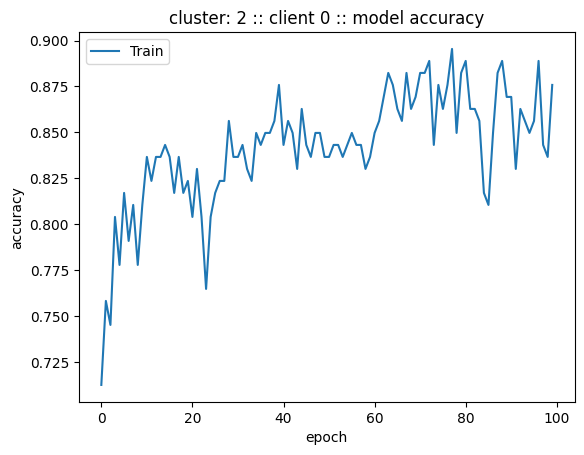

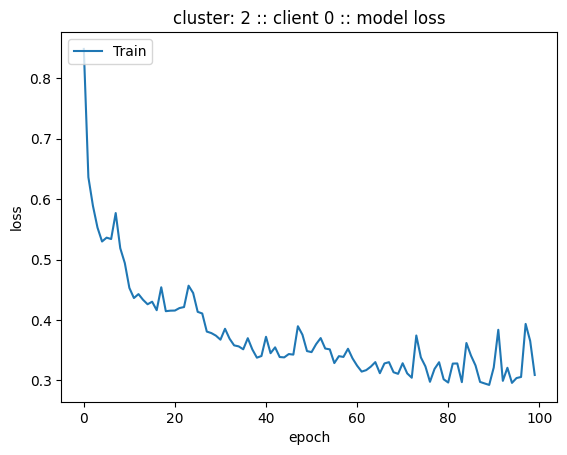

5/5 [==============================] - 0s 7ms/step - loss: 0.3025 - accuracy: 0.8758
Loss: 0.30, Accuracy: 87.58%
Epoch 1/100
16/16 [==============================] - 2s 4ms/step - loss: 0.5160 - accuracy: 0.7255
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4525 - accuracy: 0.7908
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4435 - accuracy: 0.7712
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4482 - accuracy: 0.7908
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4277 - accuracy: 0.8431
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4206 - accuracy: 0.8170
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.4160 - accuracy: 0.8105
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3743 - accuracy: 0.8301
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4020 - accuracy: 0.

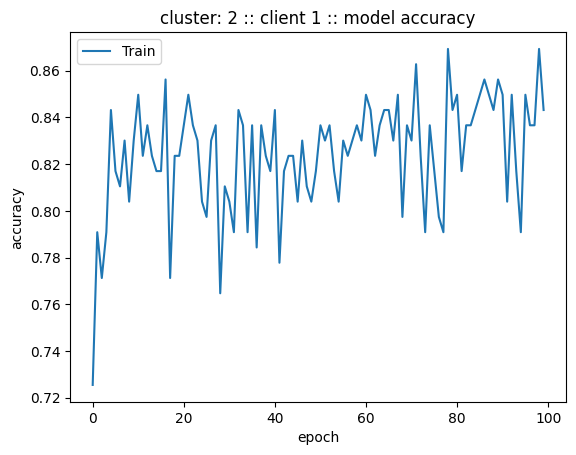

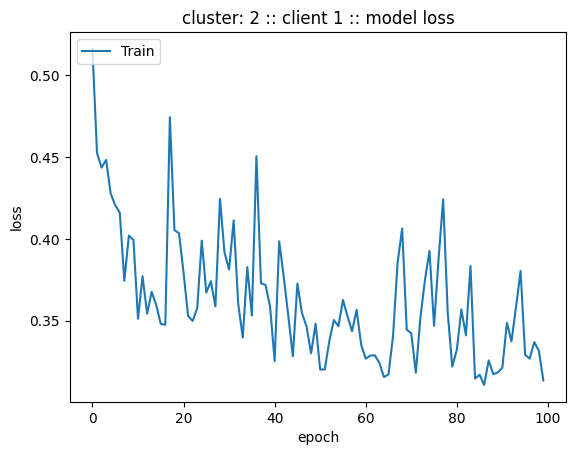

5/5 [==============================] - 0s 4ms/step - loss: 0.3025 - accuracy: 0.8497
Loss: 0.30, Accuracy: 84.97%
Epoch 1/100
16/16 [==============================] - 1s 6ms/step - loss: 0.3792 - accuracy: 0.8889
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3761 - accuracy: 0.9020
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3780 - accuracy: 0.8954
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3786 - accuracy: 0.8954
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3978 - accuracy: 0.8824
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4074 - accuracy: 0.8824
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3684 - accuracy: 0.8954
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3875 - accuracy: 0.8889
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.3764 - accuracy: 0.

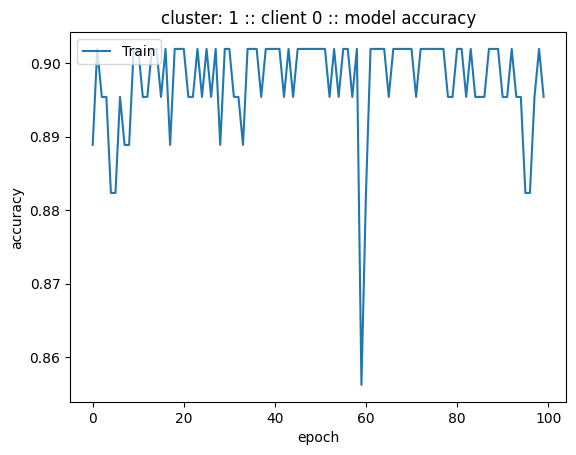

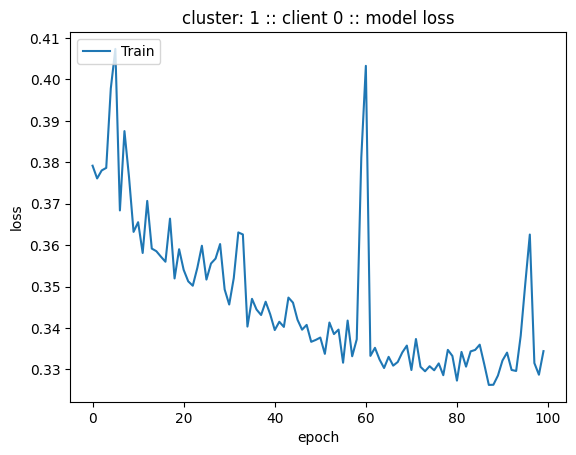

5/5 [==============================] - 0s 4ms/step - loss: 0.3260 - accuracy: 0.9020
Loss: 0.33, Accuracy: 90.20%
Epoch 1/100
16/16 [==============================] - 2s 4ms/step - loss: 0.2273 - accuracy: 0.9412
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.1598 - accuracy: 0.9281
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0879 - accuracy: 0.9673
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0810 - accuracy: 0.9739
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0897 - accuracy: 0.9673
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0721 - accuracy: 0.9673
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0673 - accuracy: 0.9739
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0667 - accuracy: 0.9673
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0707 - accuracy: 0.

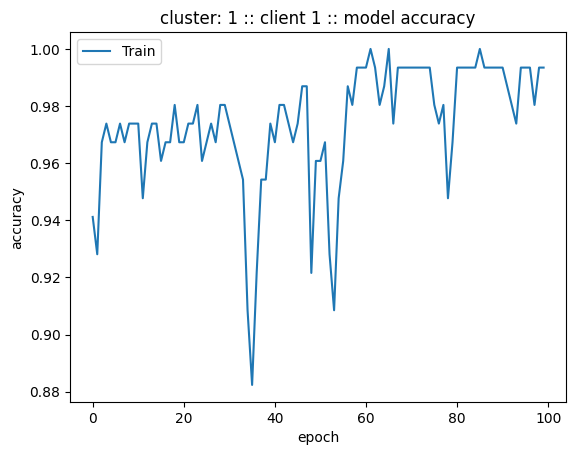

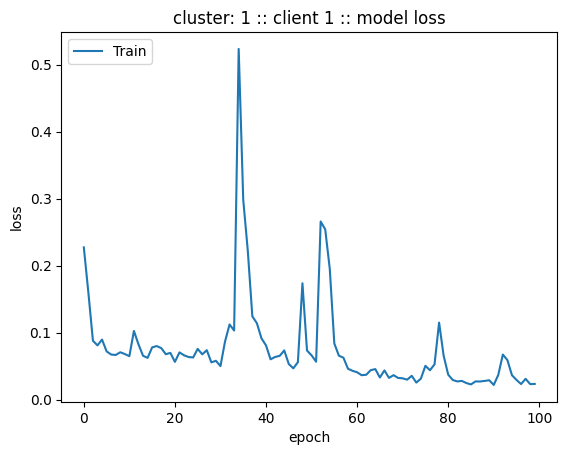

5/5 [==============================] - 0s 4ms/step - loss: 0.0188 - accuracy: 1.0000
Loss: 0.02, Accuracy: 100.00%
Epoch 1/100
16/16 [==============================] - 1s 3ms/step - loss: 0.7614 - accuracy: 0.7124
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6900 - accuracy: 0.7124
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6657 - accuracy: 0.7190
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6314 - accuracy: 0.7516
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6377 - accuracy: 0.7712
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5921 - accuracy: 0.7647
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.7001 - accuracy: 0.7124
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6067 - accuracy: 0.7908
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6204 - accuracy: 0

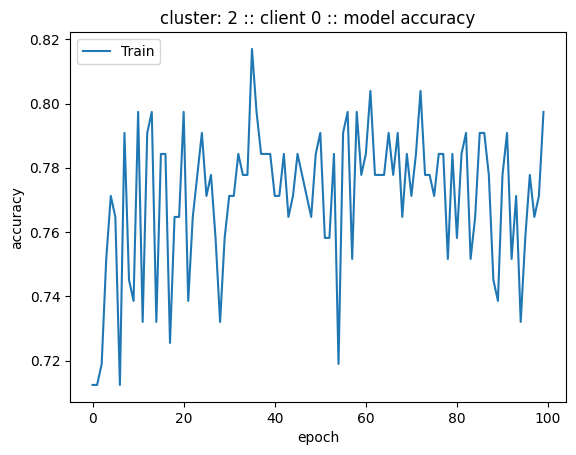

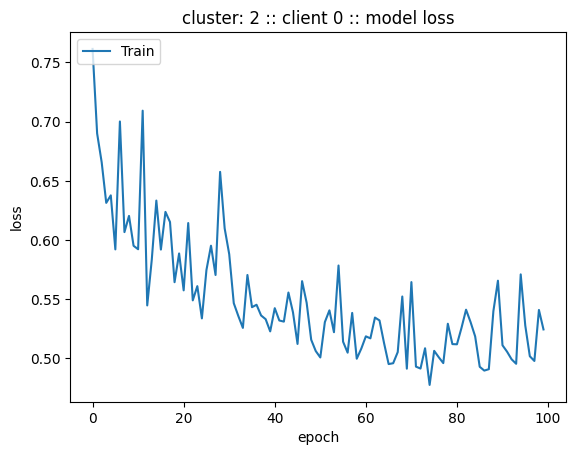

5/5 [==============================] - 0s 5ms/step - loss: 0.4654 - accuracy: 0.8039
Loss: 0.47, Accuracy: 80.39%
Epoch 1/100
16/16 [==============================] - 1s 4ms/step - loss: 0.4734 - accuracy: 0.7647
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4551 - accuracy: 0.8039
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4176 - accuracy: 0.8235
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4684 - accuracy: 0.7647
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4307 - accuracy: 0.7843
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4238 - accuracy: 0.8366
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4291 - accuracy: 0.8170
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4270 - accuracy: 0.8039
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4304 - accuracy: 0.

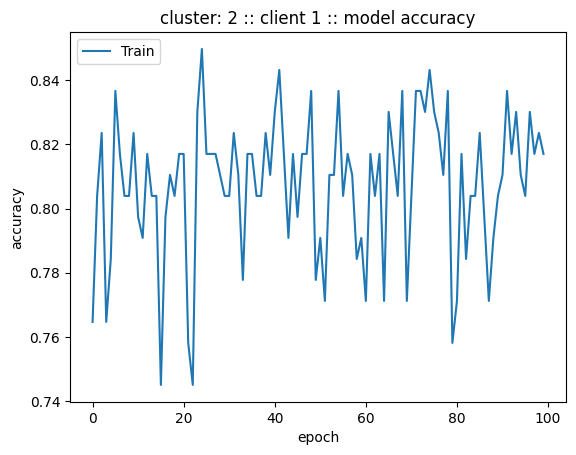

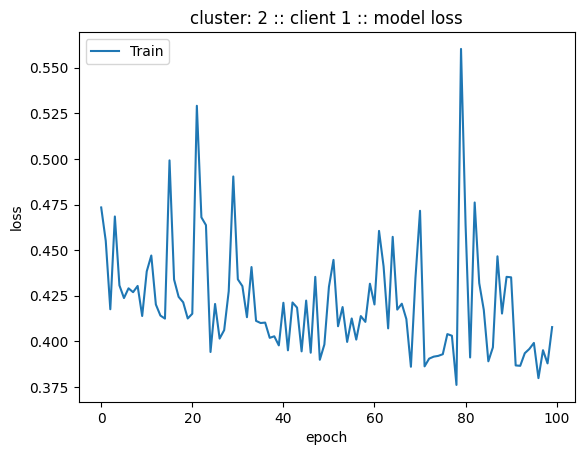

5/5 [==============================] - 0s 3ms/step - loss: 0.3804 - accuracy: 0.8301
Loss: 0.38, Accuracy: 83.01%


In [ ]:
CFL(10, 100, 10, 3, 2, 2)

In [ ]:
def test_the_gloabl_model():
  # prepare the whole dataset for the testing
  X_list = []
  y_list = []
  list_data = data.values.tolist()
  for each_data in list_data:
    temp = []
    for i in range(11):
      temp.append(each_data[i])
    X_list.append(temp)
    y_list.append(each_data[11])

  X = np.asarray(X_list, dtype=np.float32)
  y = np.asarray(y_list, dtype=np.float32)

  # test the latest model
  global current_models

  ultimate_predictions = []

  for curr_model in current_models:
    latest_model = curr_model
    latest_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Evaluate the model
    loss, accuracy = latest_model.evaluate(X, y)
    print(f'Loss: {loss:.2f}, Accuracy: {accuracy*100:.2f}%')

    # confusion matrix creation for current model
    y_pred = latest_model.predict(X)
    ultimate_predictions.append(y_pred)
    y_pred_ultimate = []
    for each_ele in y_pred:
      if(each_ele[0]>=0.5): y_pred_ultimate.append(1.0)
      else: y_pred_ultimate.append(0.0)
    y_pred_ultimate = np.array(y_pred_ultimate)
    cm = confusion_matrix(y, y_pred_ultimate)

    cm_df = pd.DataFrame(cm,
                      index = ['NORMAL','HEART DISEASE'],
                      columns = ['NORMAL','HEART DISEASE'])

    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()

  y_pred_global = []
  for i in range(len(ultimate_predictions[0])):
    if((ultimate_predictions[0][i]+ultimate_predictions[1][i]+ultimate_predictions[2][i])/3>=0.5): y_pred_global.append(1.0)
    else: y_pred_global.append(0.0)
  y_pred_global = np.array(y_pred_global)

  cm = confusion_matrix(y, y_pred_global)

  cm_df = pd.DataFrame(cm,
                      index = ['NORMAL','HEART DISEASE'],
                      columns = ['NORMAL','HEART DISEASE'])

  plt.figure(figsize=(5,4))
  sns.heatmap(cm_df, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()

  global_accuracy = cm.diagonal()/cm.sum(axis=1)

  print(f"accuracy for NORMAL class: {round(global_accuracy[0]*100, 2)}%")
  print(f"accuracy for HEART DISEASE class: {round(global_accuracy[1]*100, 2)}%")

  print(f"global accuracy: {round(((global_accuracy[0]+global_accuracy[1])/2)*100, 2)}%")

29/29 [==============================] - 0s 3ms/step - loss: 1.6654 - accuracy: 0.7996
Loss: 1.67, Accuracy: 79.96%
29/29 [==============================] - 0s 3ms/step


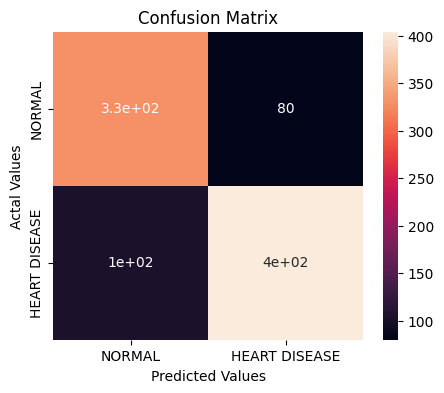

29/29 [==============================] - 0s 3ms/step - loss: 0.7412 - accuracy: 0.8224
Loss: 0.74, Accuracy: 82.24%
29/29 [==============================] - 0s 2ms/step


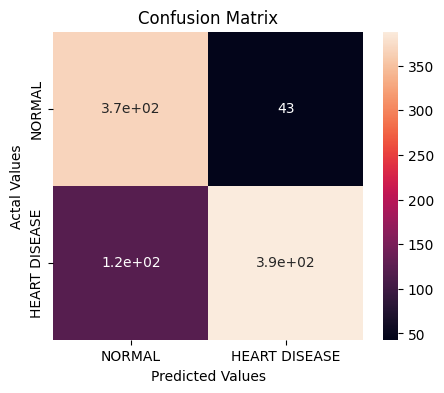

29/29 [==============================] - 0s 3ms/step - loss: 0.4062 - accuracy: 0.8410
Loss: 0.41, Accuracy: 84.10%
29/29 [==============================] - 0s 2ms/step


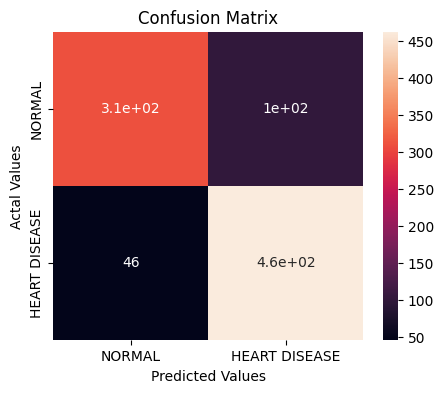

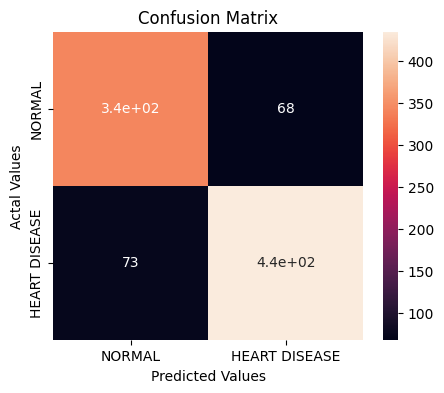

accuracy for NORMAL class: 83.41%
accuracy for HEART DISEASE class: 85.63%
global accuracy: 84.52%


In [ ]:
test_the_gloabl_model()